# Program for statistical analysis (3rd step)
## This program runs over the data given by snap analysis. 
## Input

### * this program would need the documents: "MotherData.csv" and "AllCellData.csv"

### *If you want to compare some periods of time, you must to edit the array of snaps called 'referencesnap' in second box. Also you can put some annotations.

## Output

### This program will fit the cell lengths over time and will compute dinamically, the growth rate.
### Also it will be computed size and fluorescense distributions among some time intervals
### it will plot autocorrelation for mother's GFP and RFP 
### it will plot correlation between mother and its sisters as a indirect measure of noise.
### it could be usefull a phase diagram of growth rate vs protein expression.

In [1]:
%matplotlib inline
import cv2 #Image segmentation Library
import numpy as np #Numeric functions lib
from matplotlib import pyplot as plt #Basic ploting lib
import sys
import os #Lib for get the operative system sintaxis
from glob import glob #library used for get the file paths
import seaborn as sns #Library used for a nicer plotting
from sklearn import linear_model#Machine learning package for a smart plot fit
from sklearn import datasets
import pandas as pd#data analisys library
import scipy.stats

def indexes(y,thresh,peakdist):#peak detection algorithm
    dy = np.diff(y)
    ind = []
    for i in range(len(dy)):
        if len(ind) > 0:
            if dy[i] < dy[int(i-1)] and dy[i]<-thresh and i-peakdist>ind[-1]:
                ind.append(i)
        elif len(ind) == 0:
            if dy[i] < dy[int(i-1)] and dy[i]<-thresh:
                ind.append(i)
    return ind  

def getjointplot(x,y,df,name):
    if not os.path.exists('./jointplot'):
        os.makedirs('./jointplot')
    sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
    plot = sns.jointplot(x,y,df,size=8,linewidth=2,marginal_kws=dict(bins=25))
    plot.savefig('./jointplot/name')

def setplot(a,b):
    sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=5, color_codes=False, rc=None)
    sns.axes_style('whitegrid')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    fig.text(0.5, 0.04, a,fontsize=15, ha='center')
    fig.text(0.04, 0.5, b,fontsize=15, va='center', rotation='vertical')

In [24]:
referencesnap=[0,17,38,57,77,97,117]#each list element is the snap you have taken a reference in snap analysis
timebetweenframes=6
ref=[x*timebetweenframes for x in referencesnap]#each list element is the time (min) you will take a reference
annotation=['OD=0.15','OD=0.25','OD=0.35','OD=0.45','OD=0.35','OD=0.25','OD=0.15']#each list element is te annotation you will include 
if not (len(referencesnap)+1>(len(annotation))):
    print("annotation and references does not have aproppriate sizes")

## ploting the length vs time for all mothers and computing doubling times

In [31]:
#peak detection parameters
thresh =0.5 #the min change to consider point as a peak
peakdist = 4 # the min distance between two peaks

In [32]:
data = pd.read_csv('MotherData.csv') 
alldf = pd.read_csv('AllCellData.csv')
try:
    gfp = data['MeanGFP'].unique()
    GFPimages = True
except:
    GFPimages = False
    print('there is no GFP in your data')

there is no GFP in your data


In [40]:
totaltime = data['Time(min)'].unique()

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may con

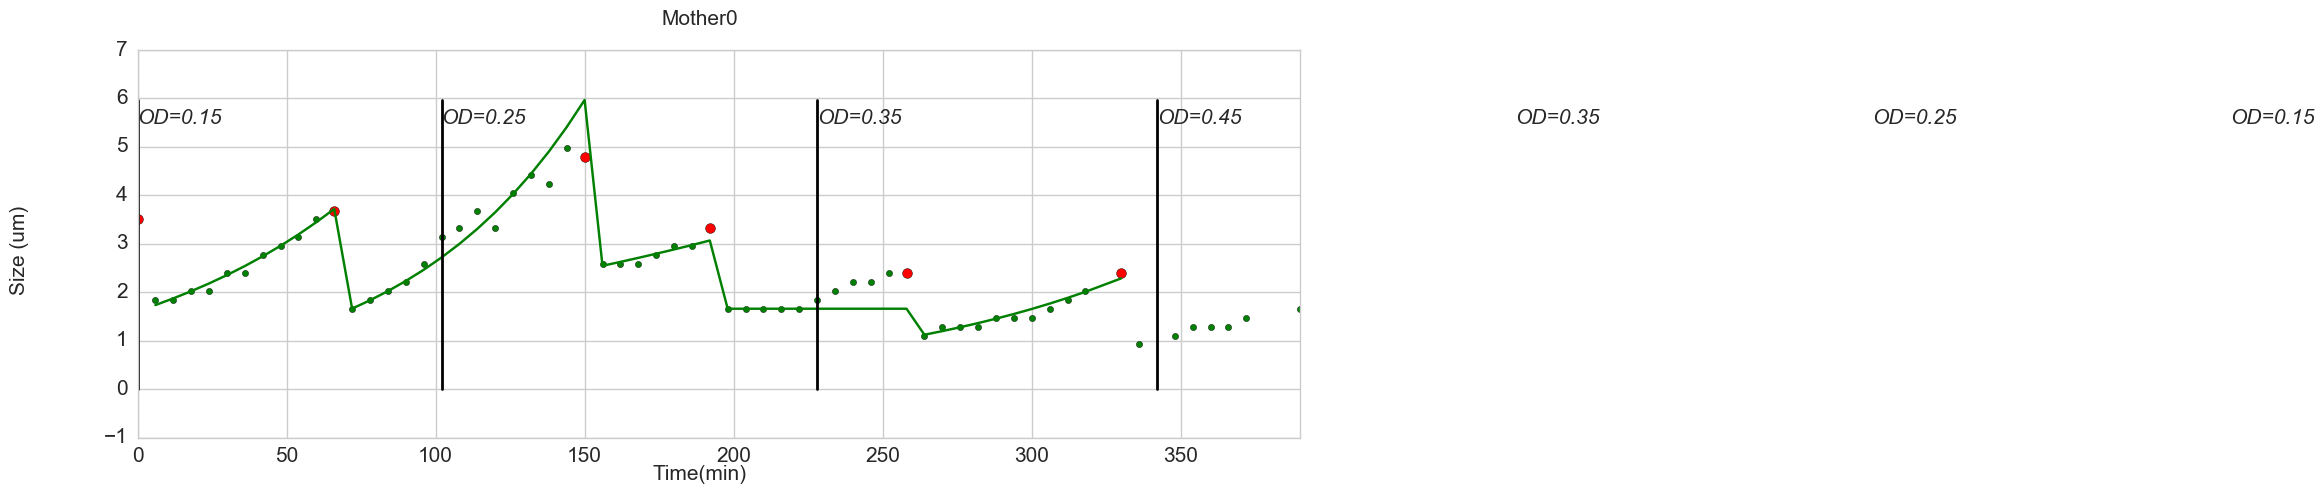

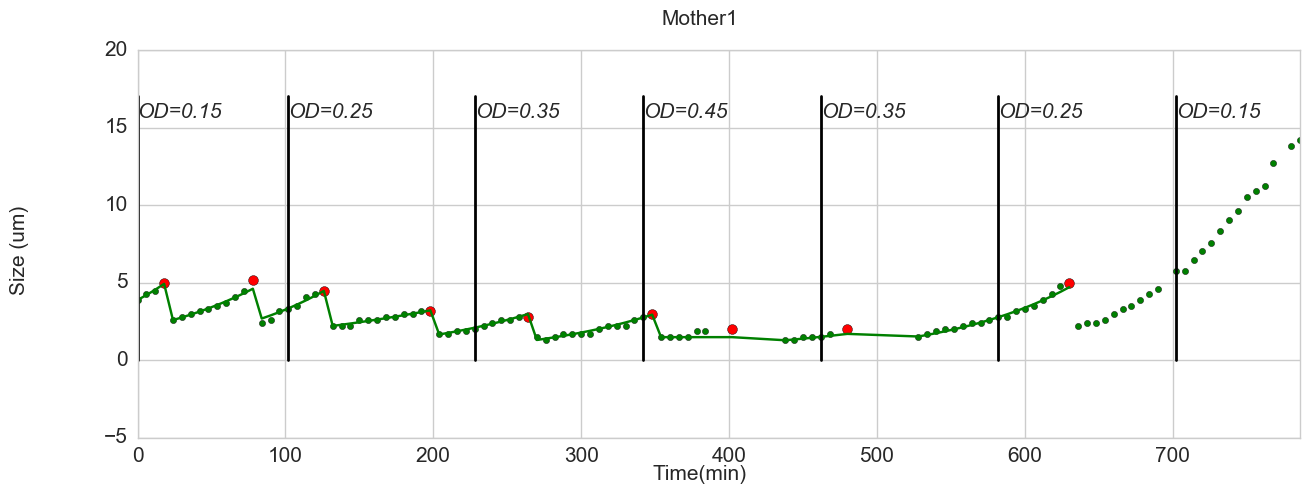

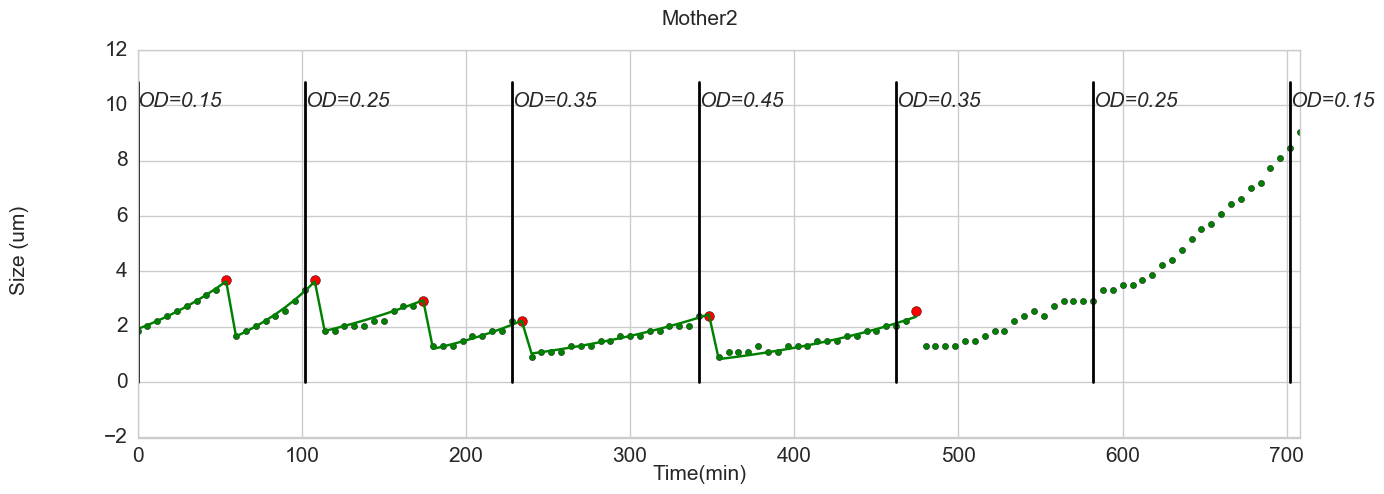

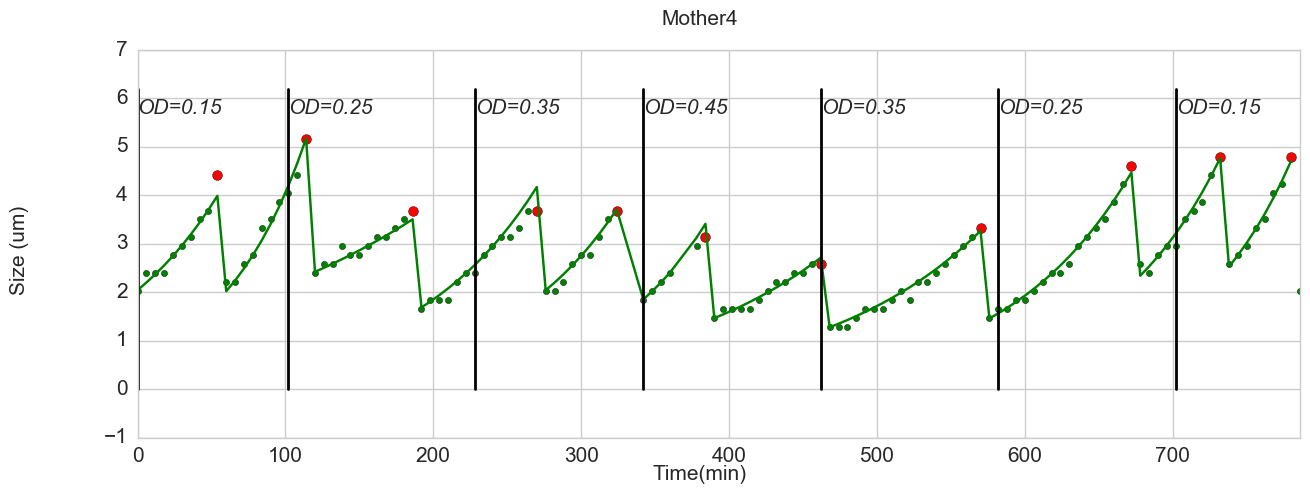

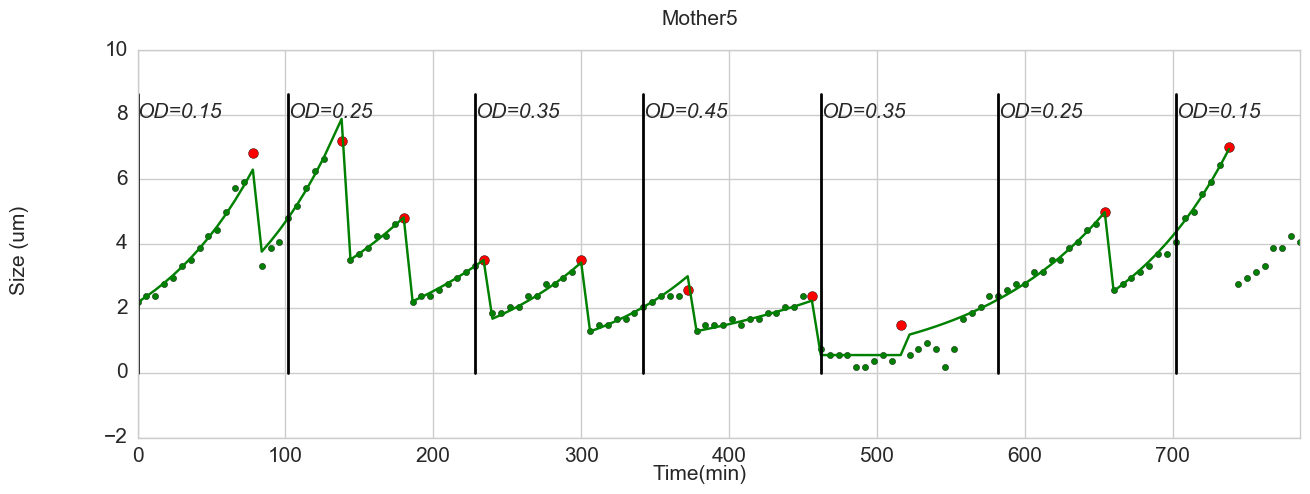

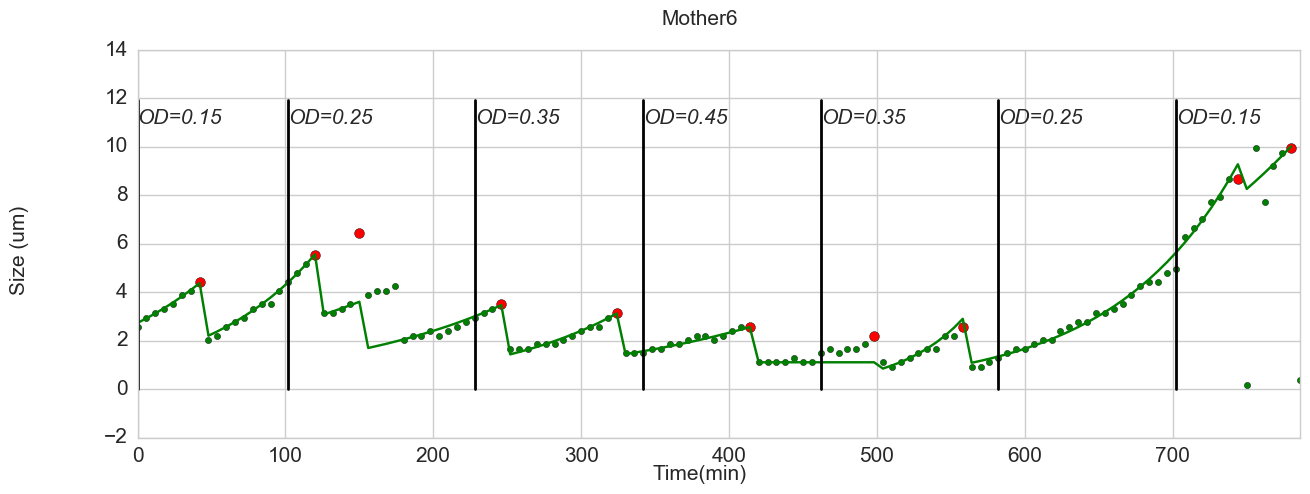

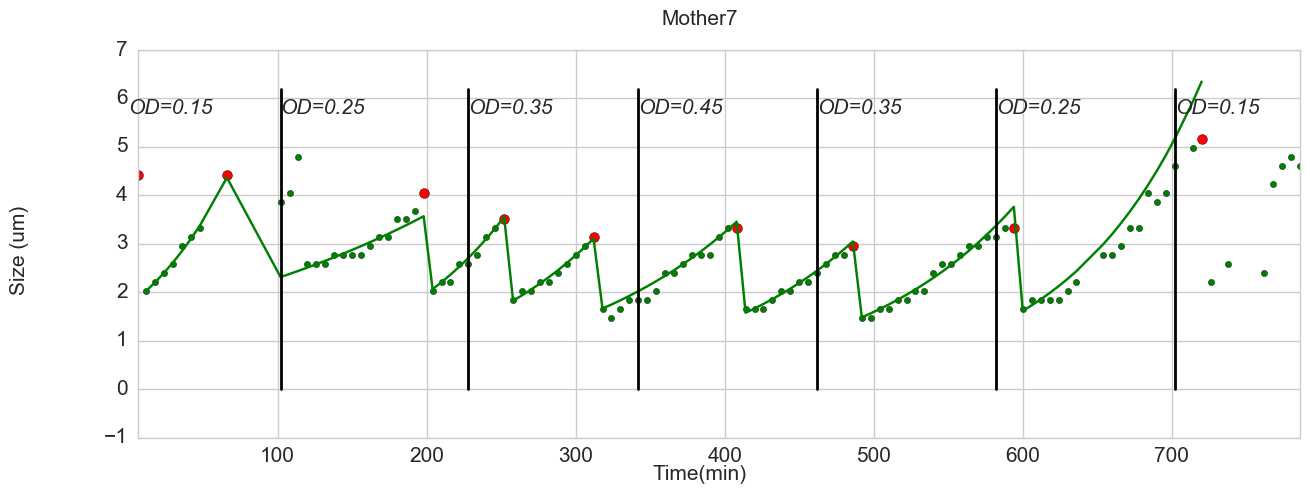

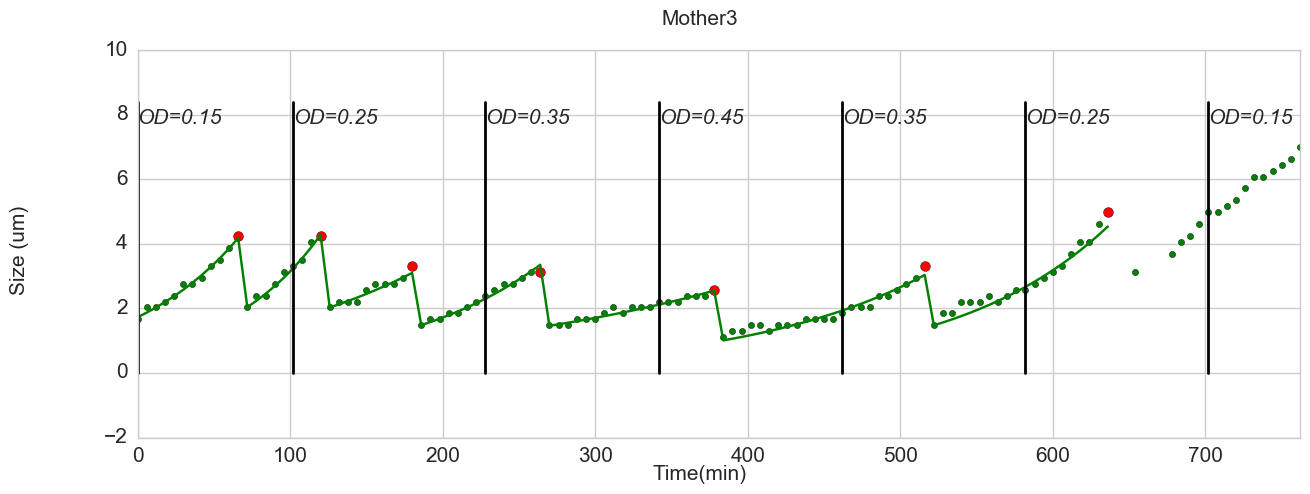

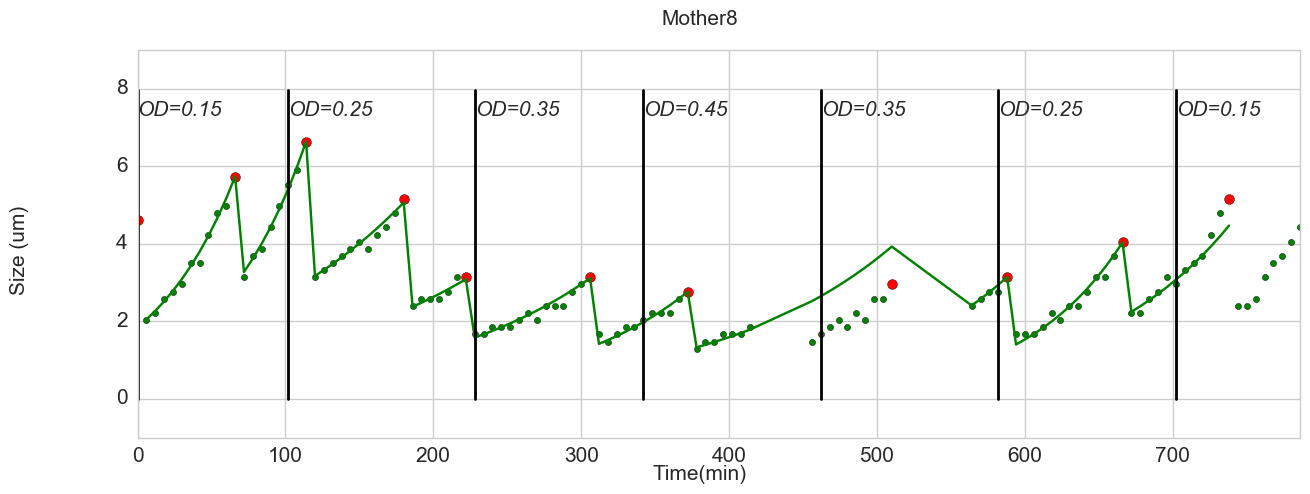

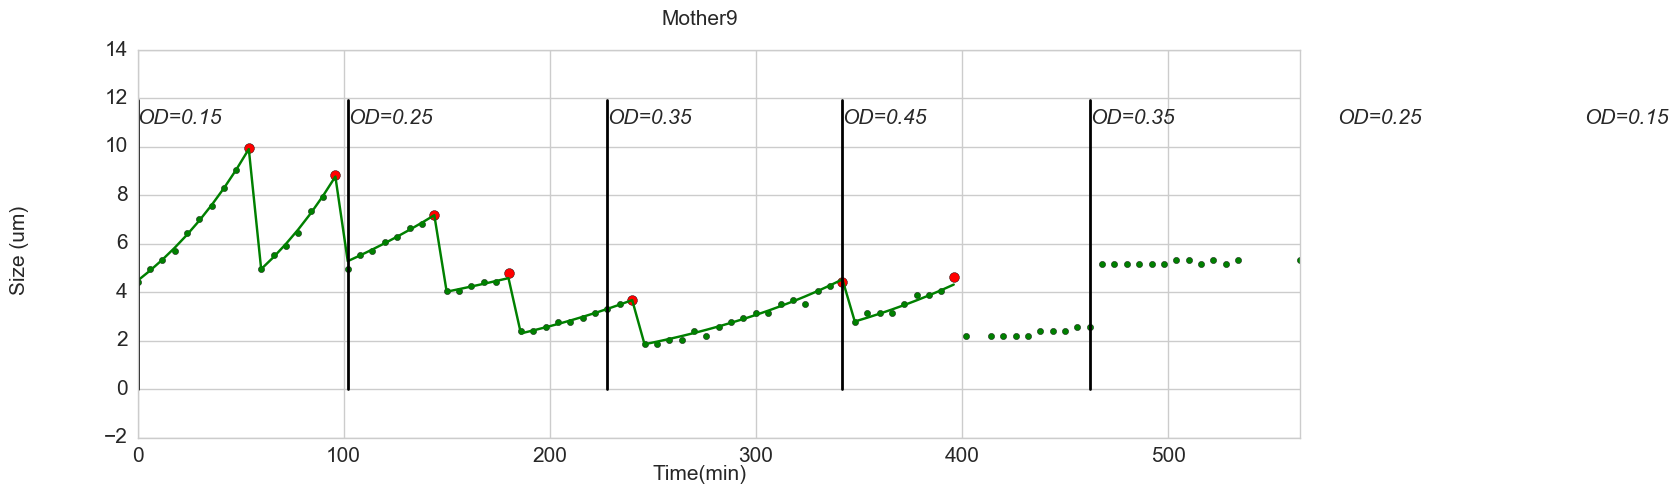

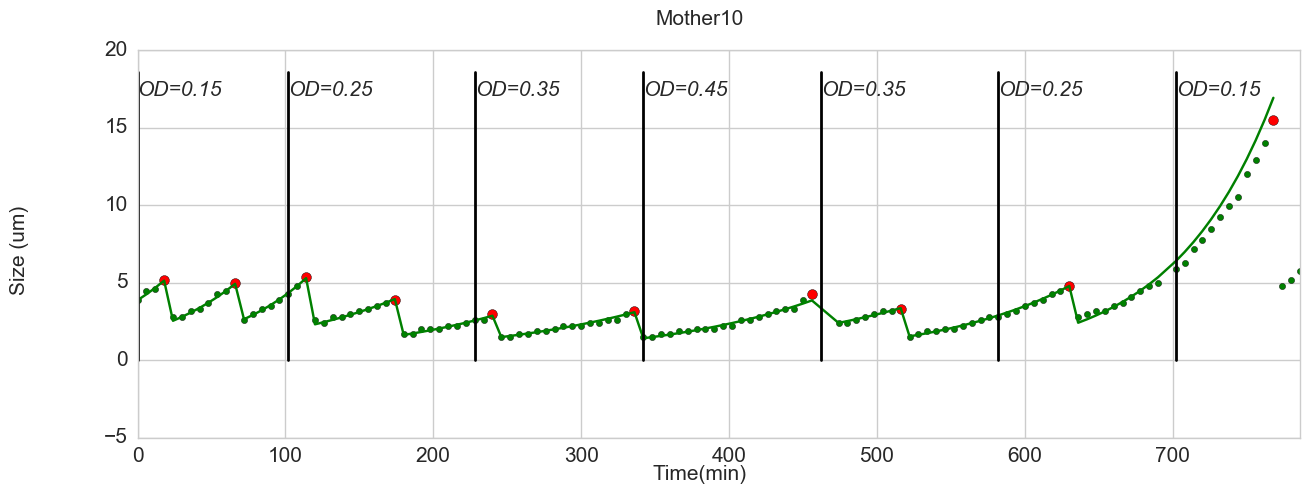

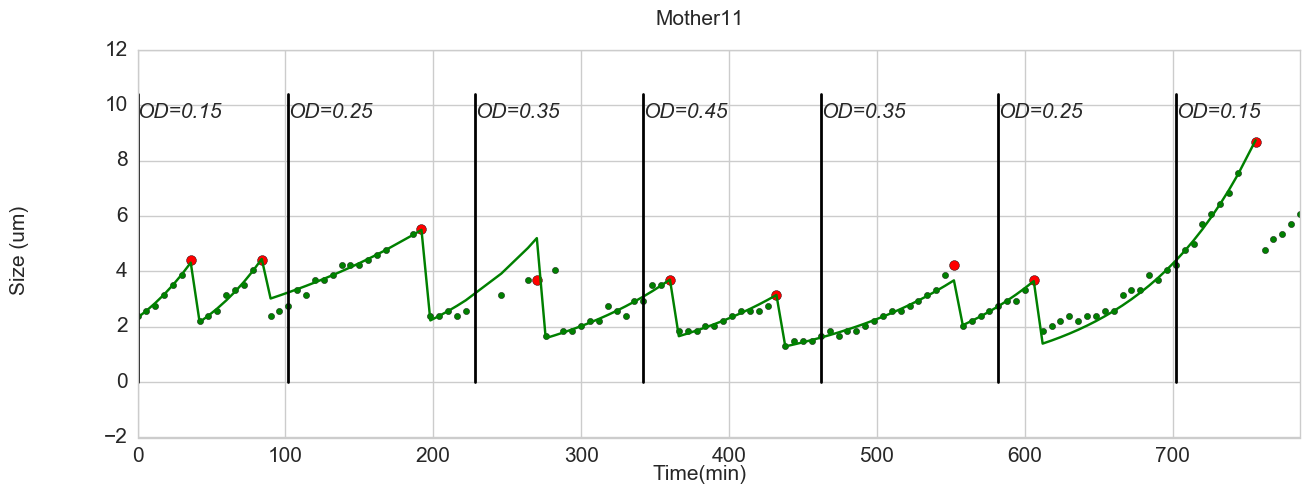

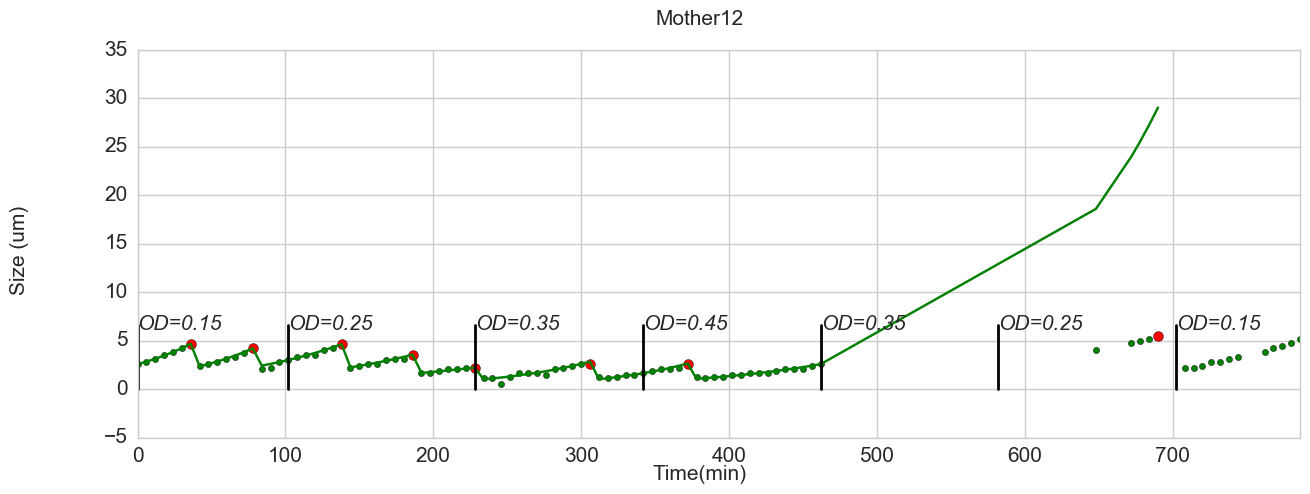

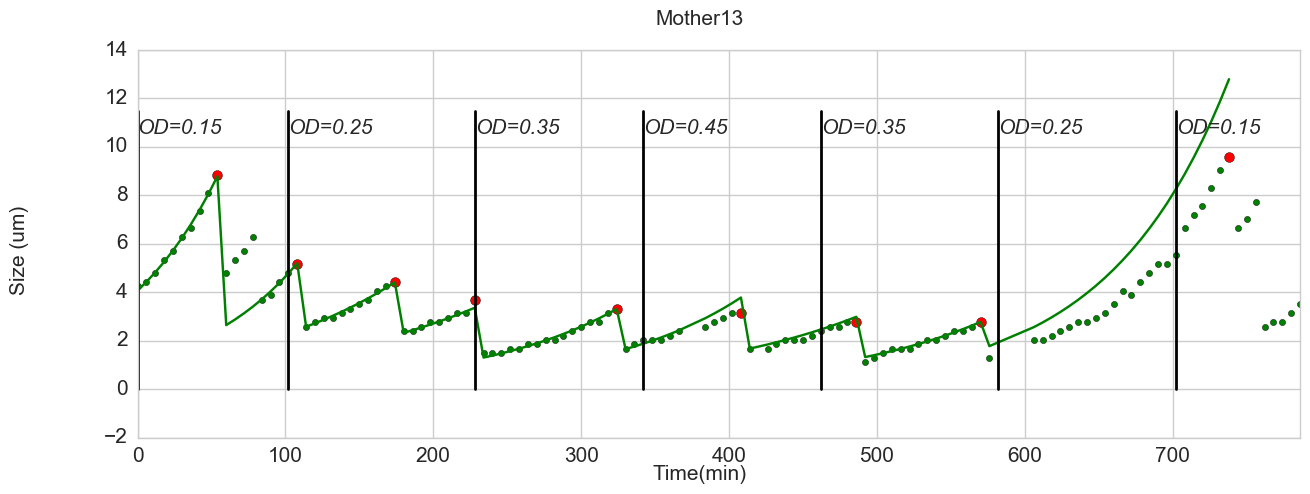

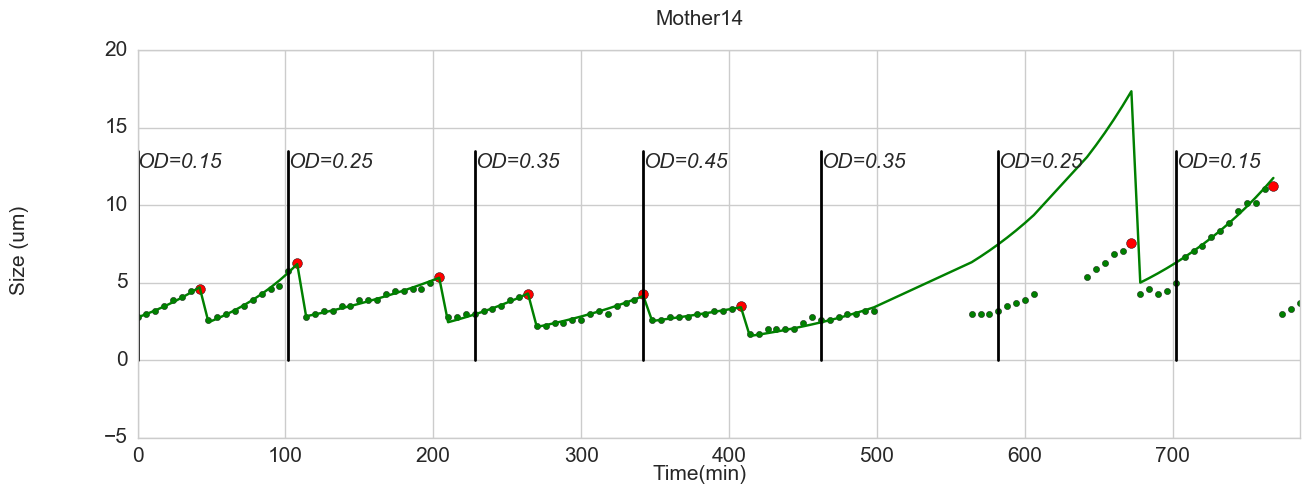

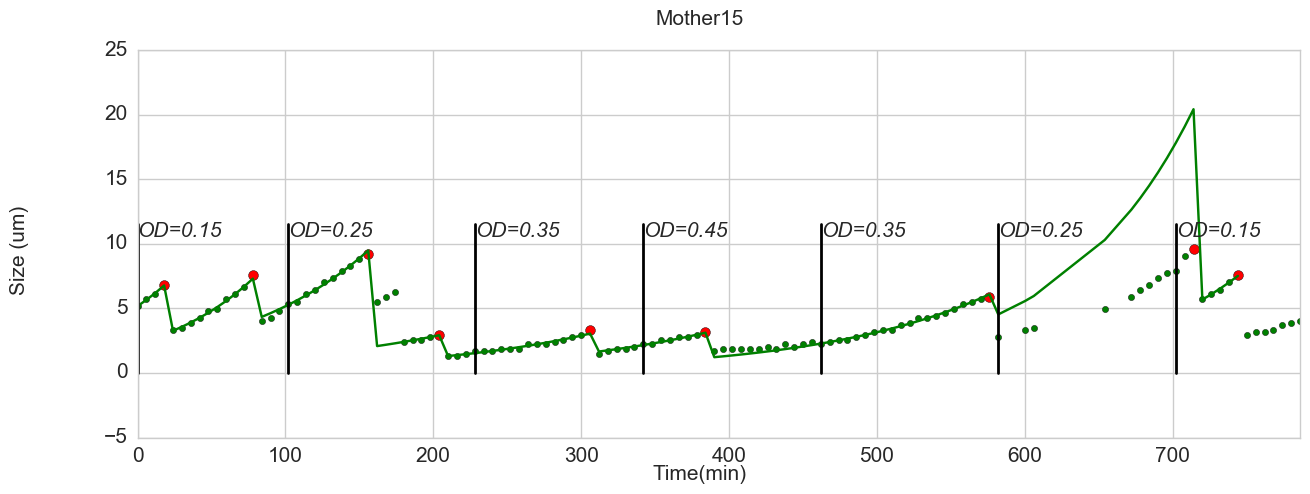

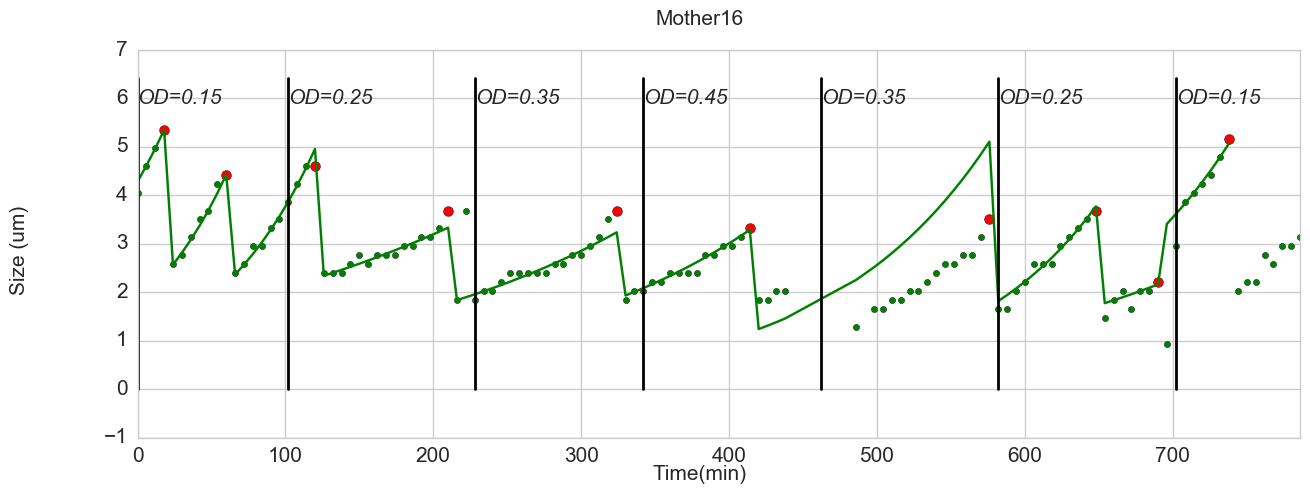

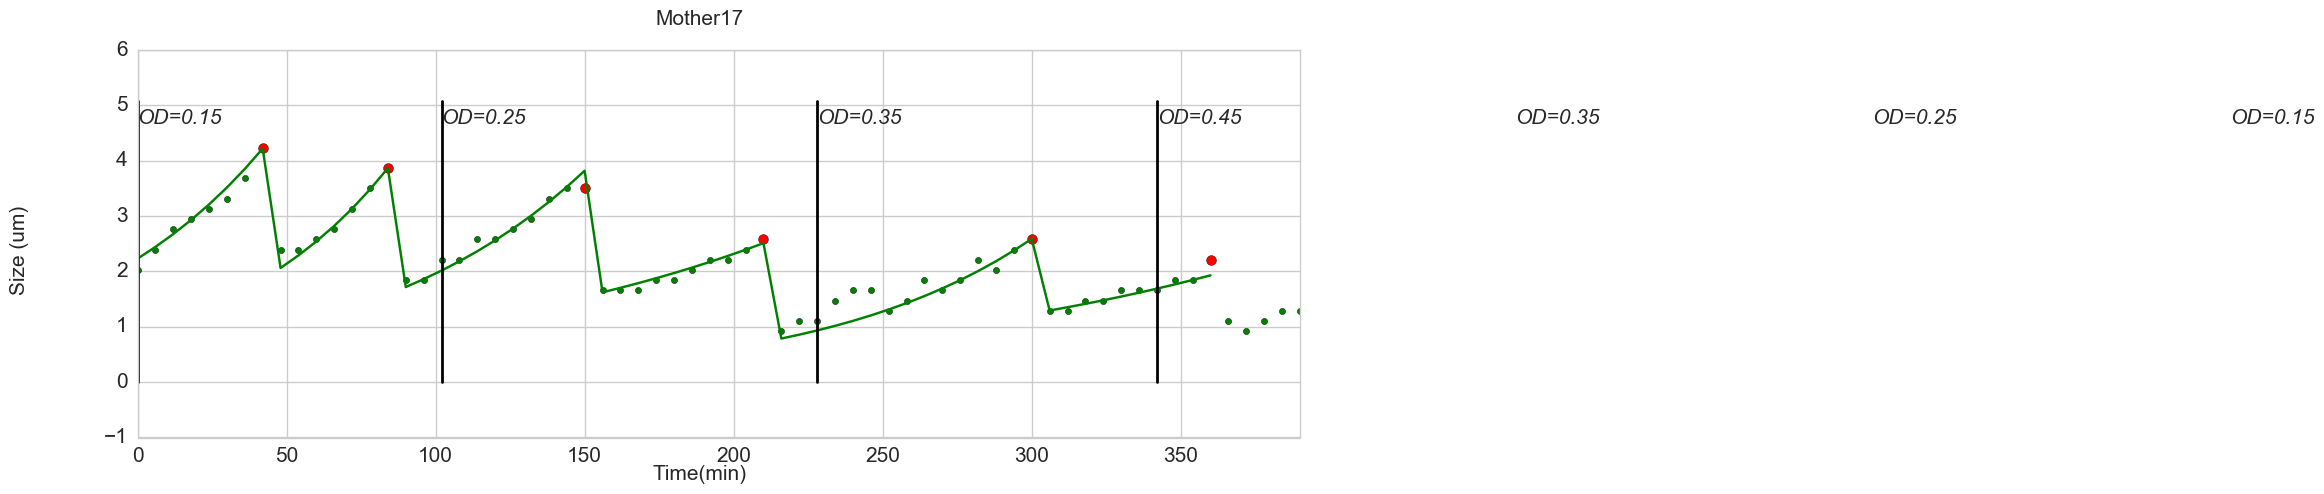

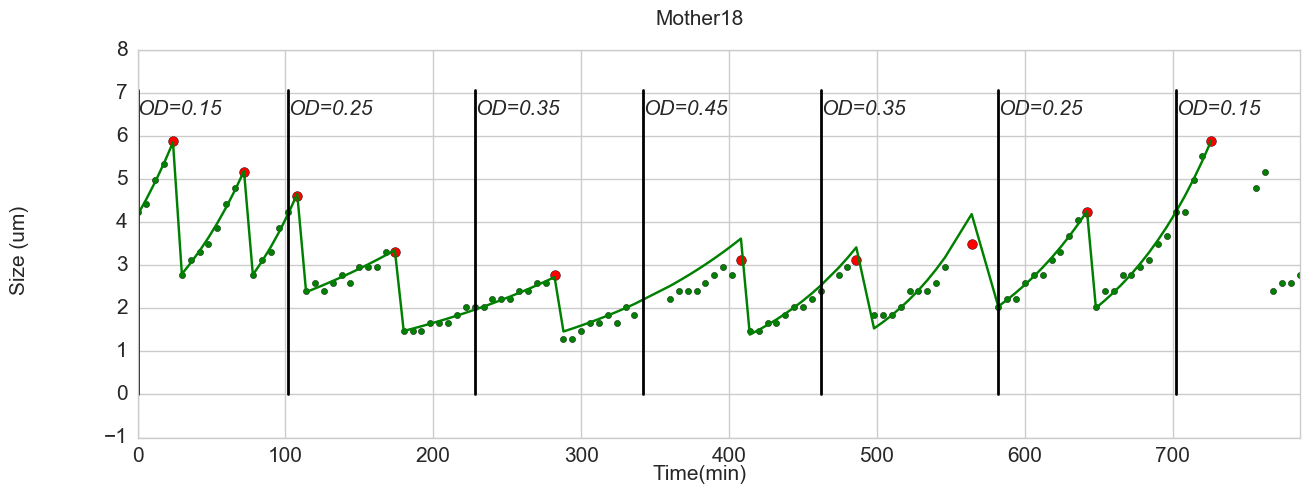

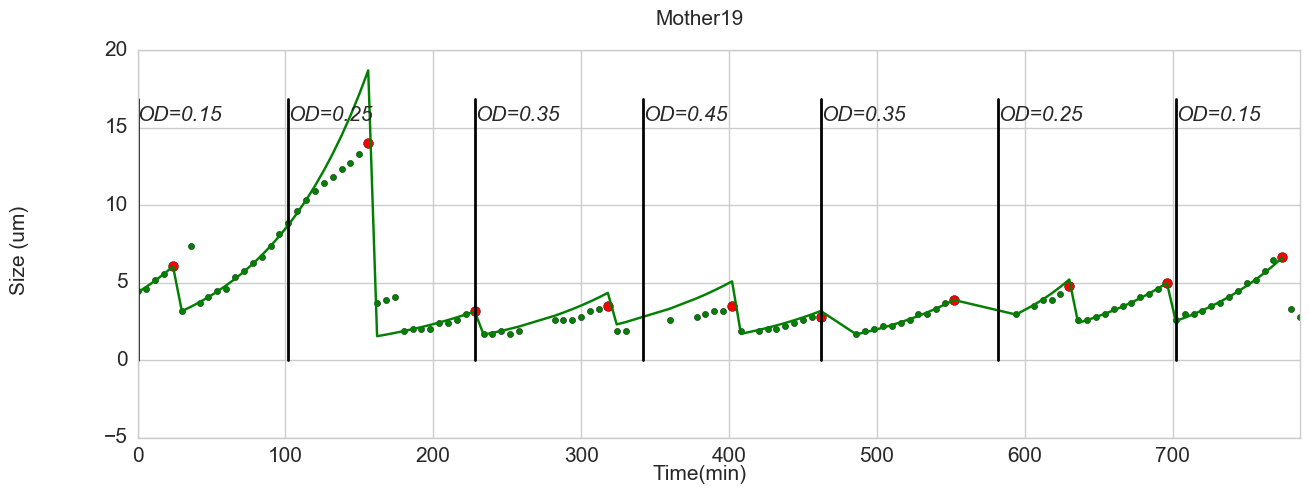

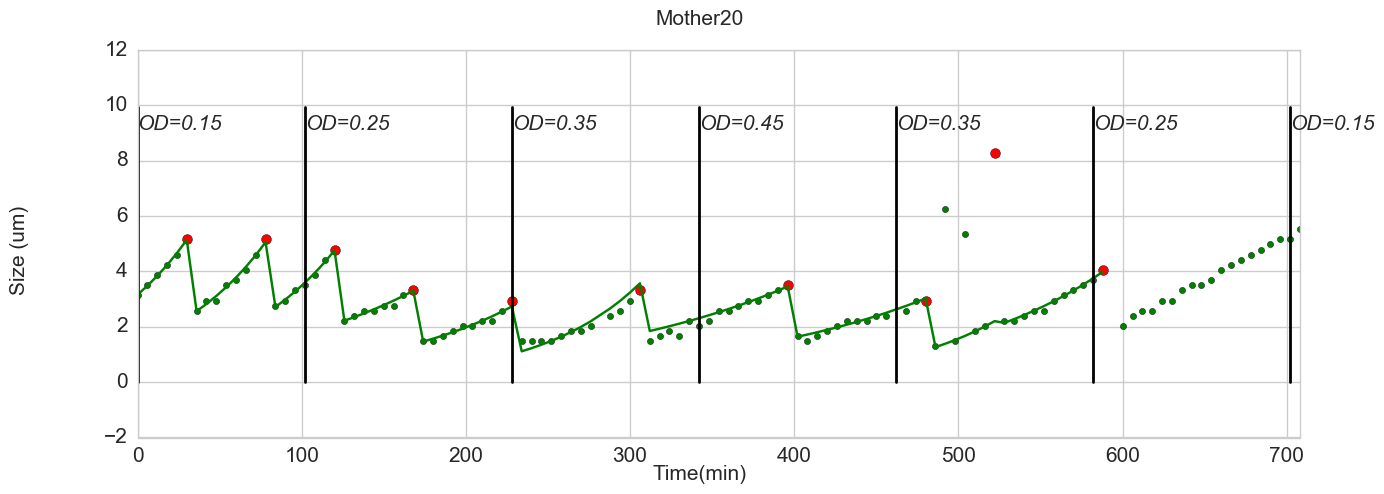

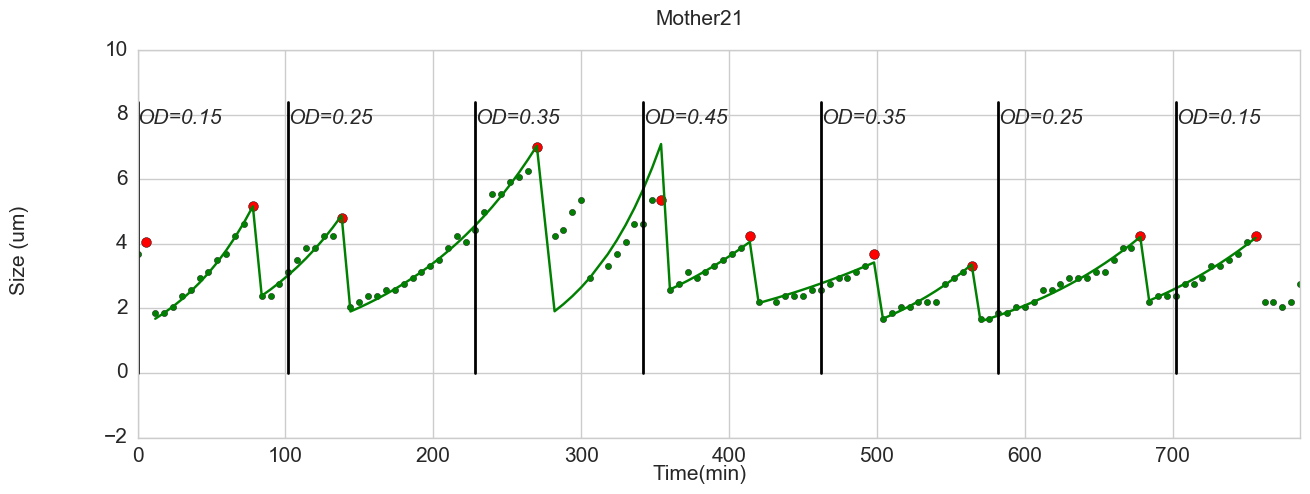

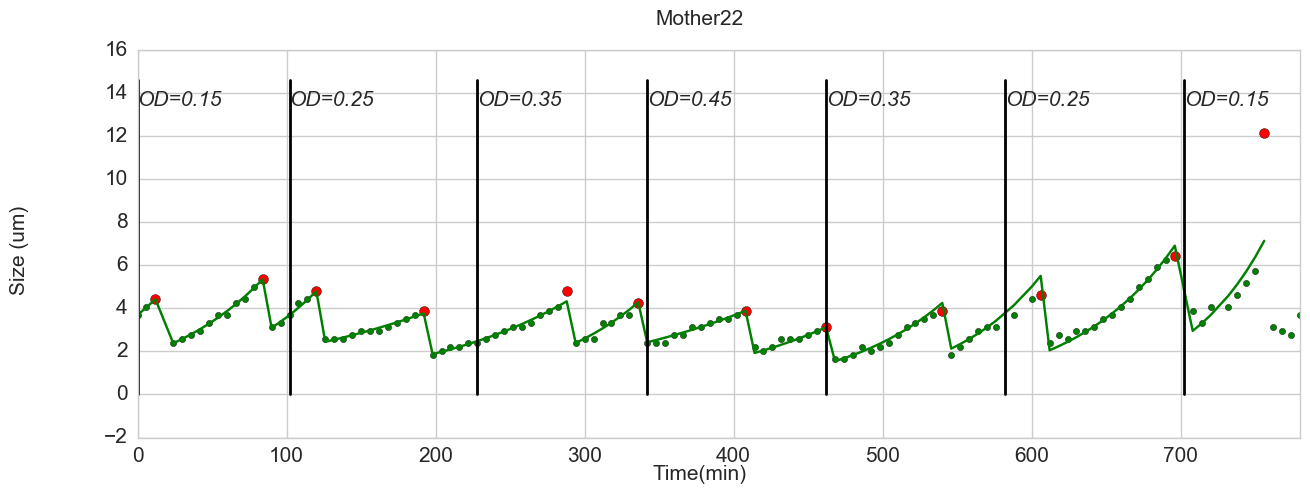

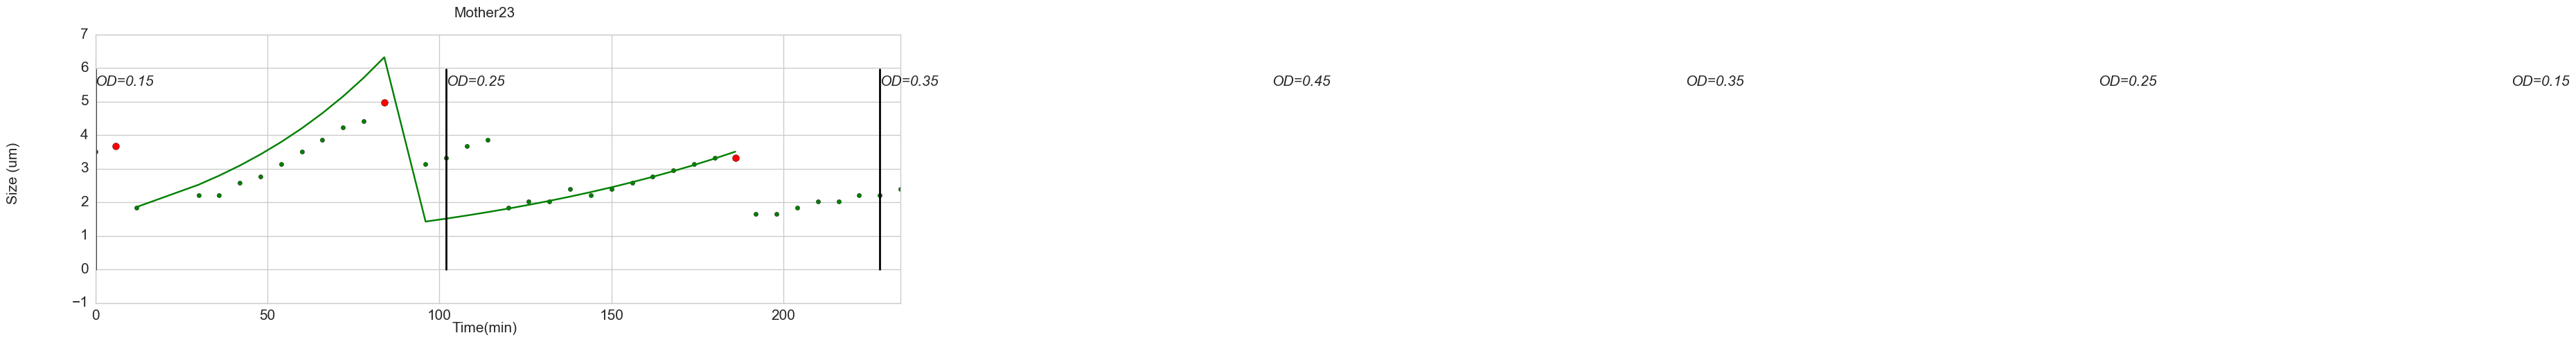

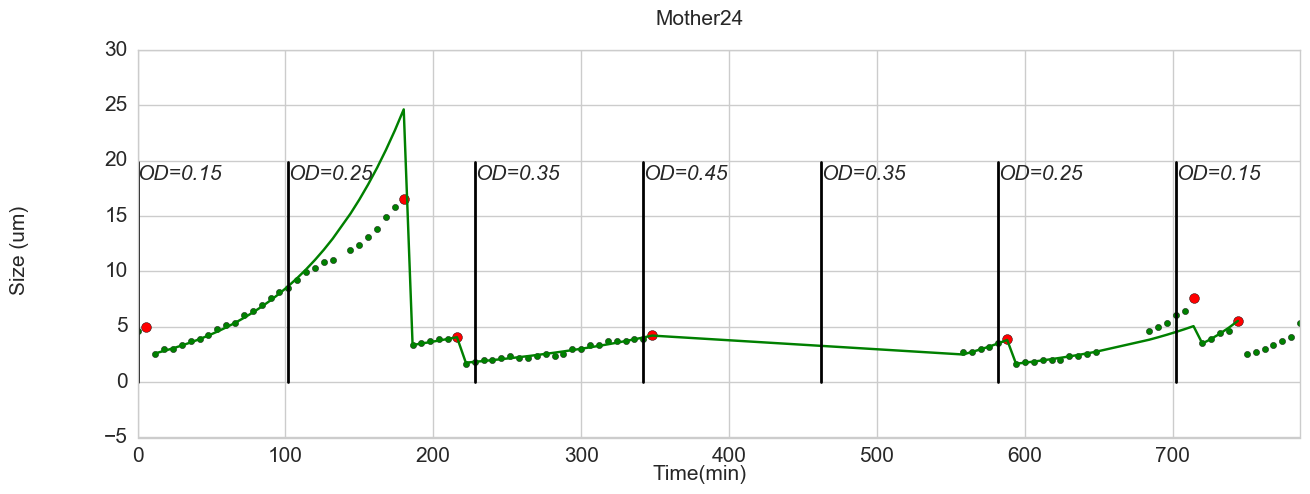

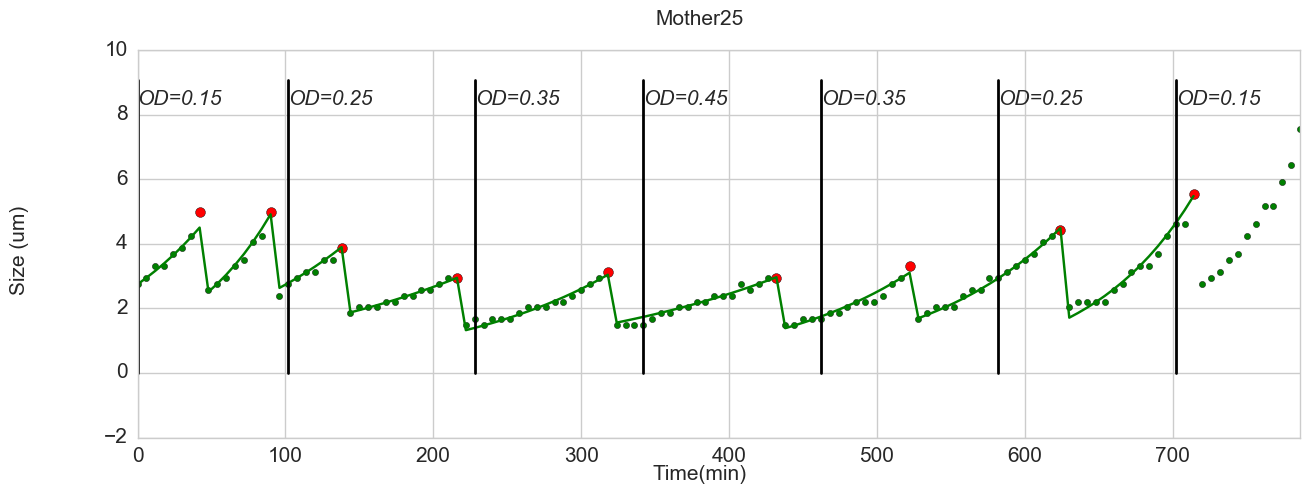

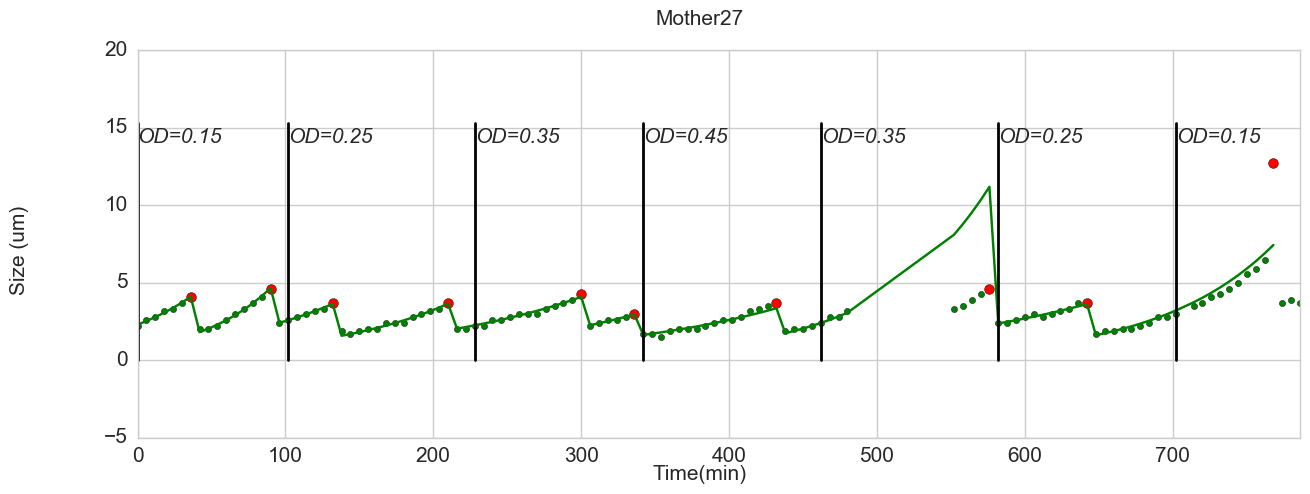

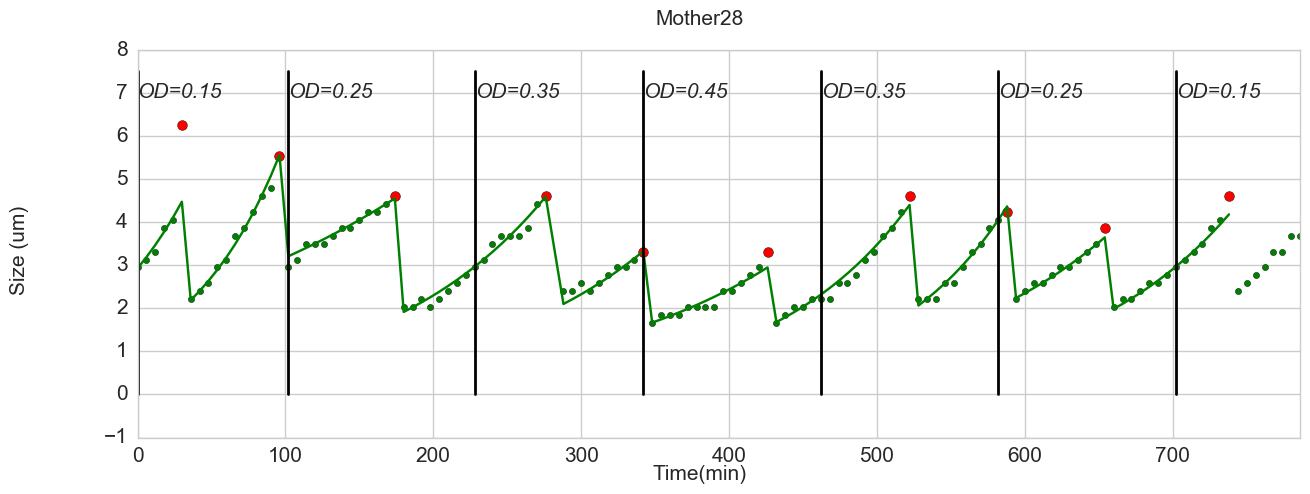

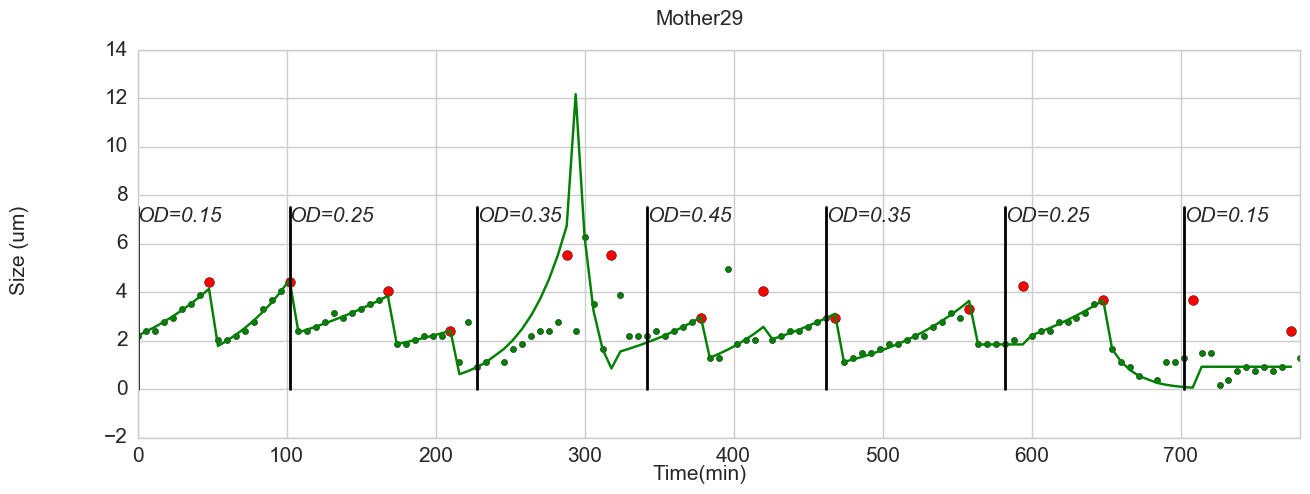

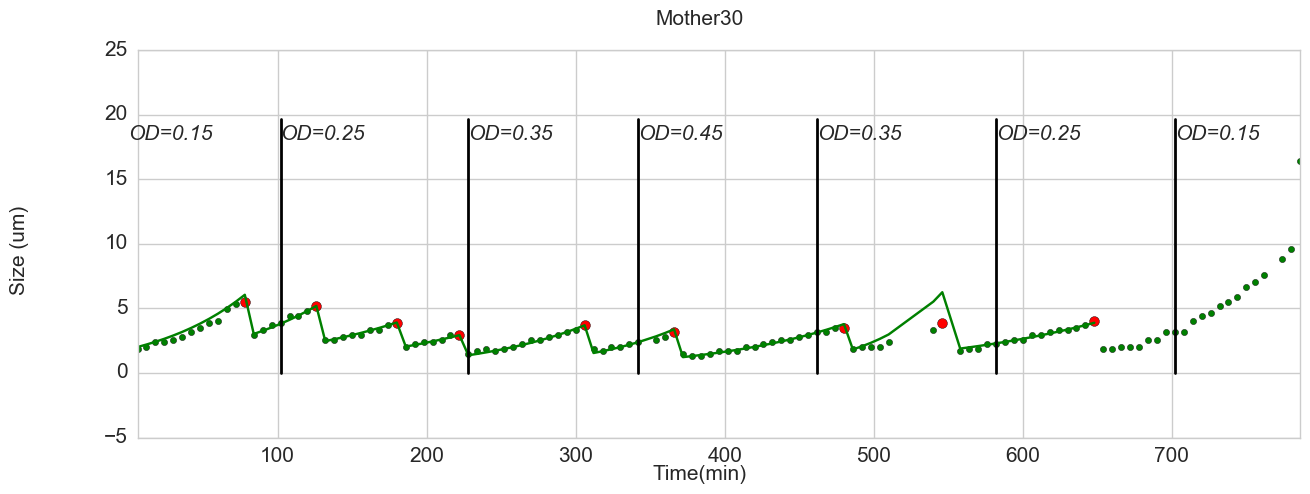

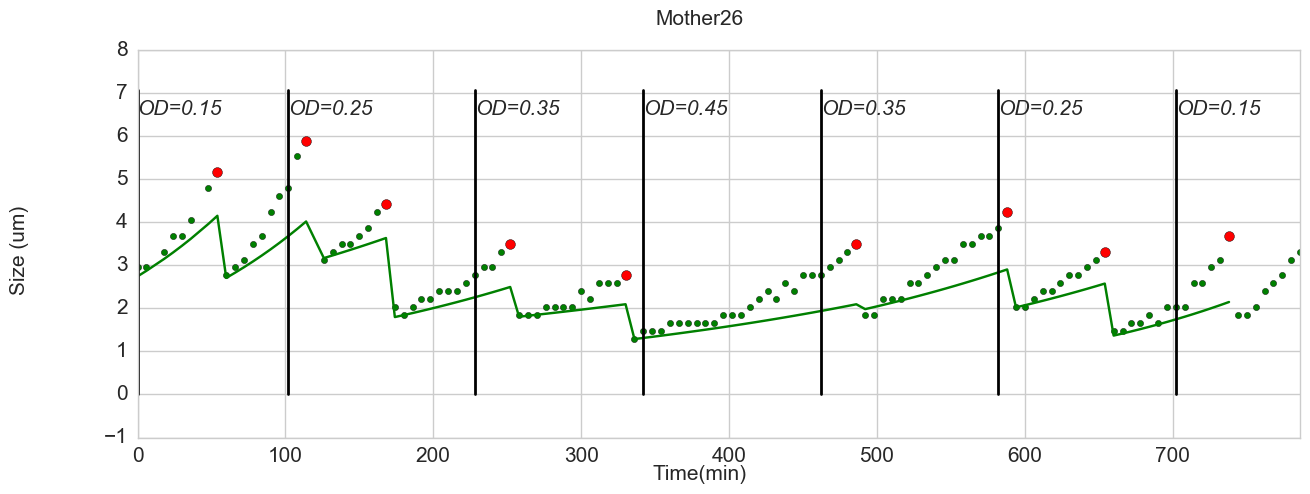

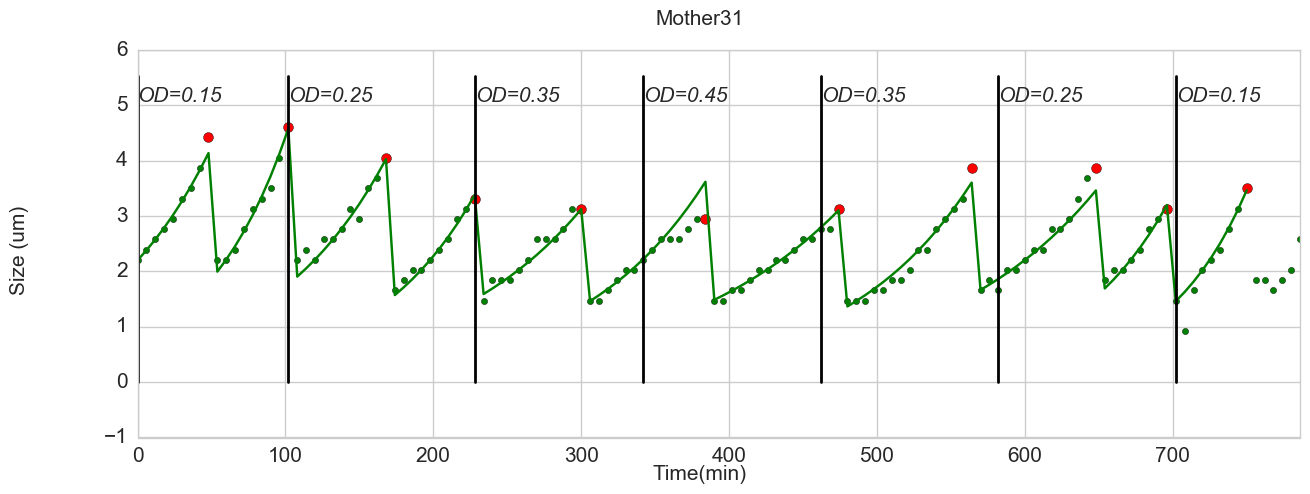

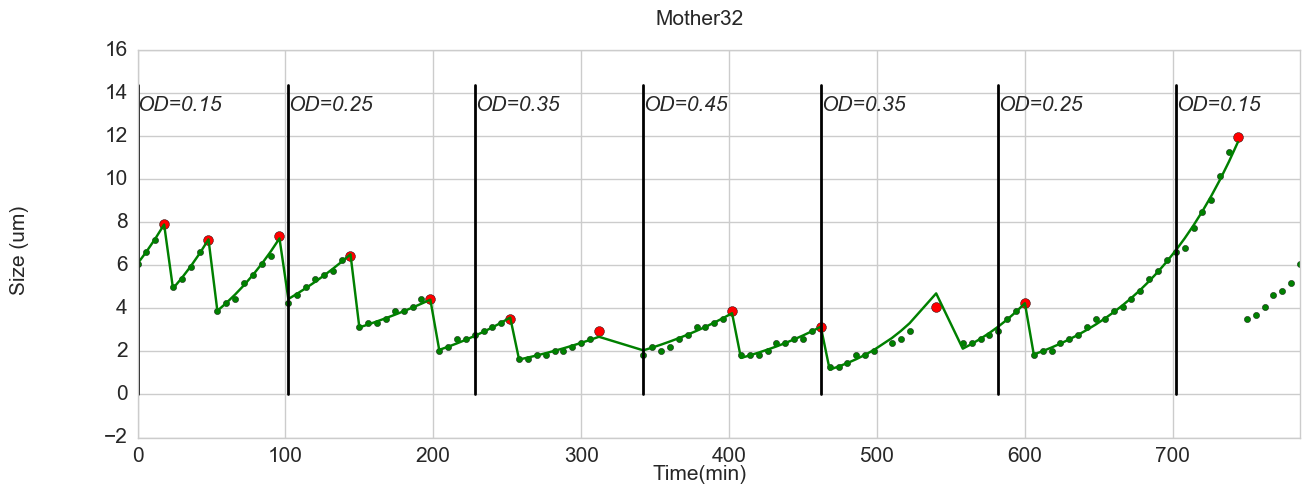

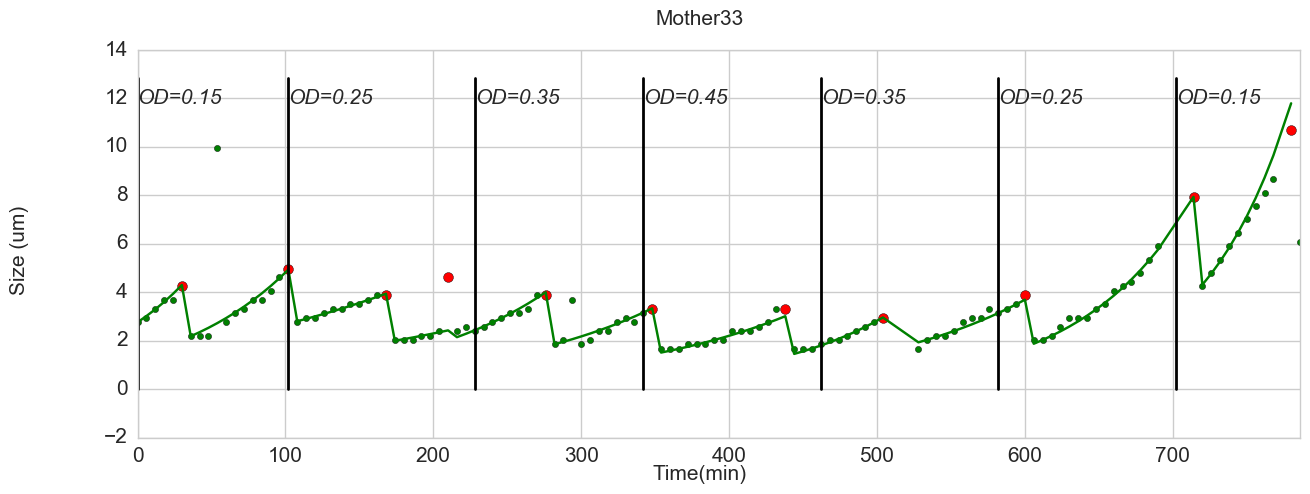

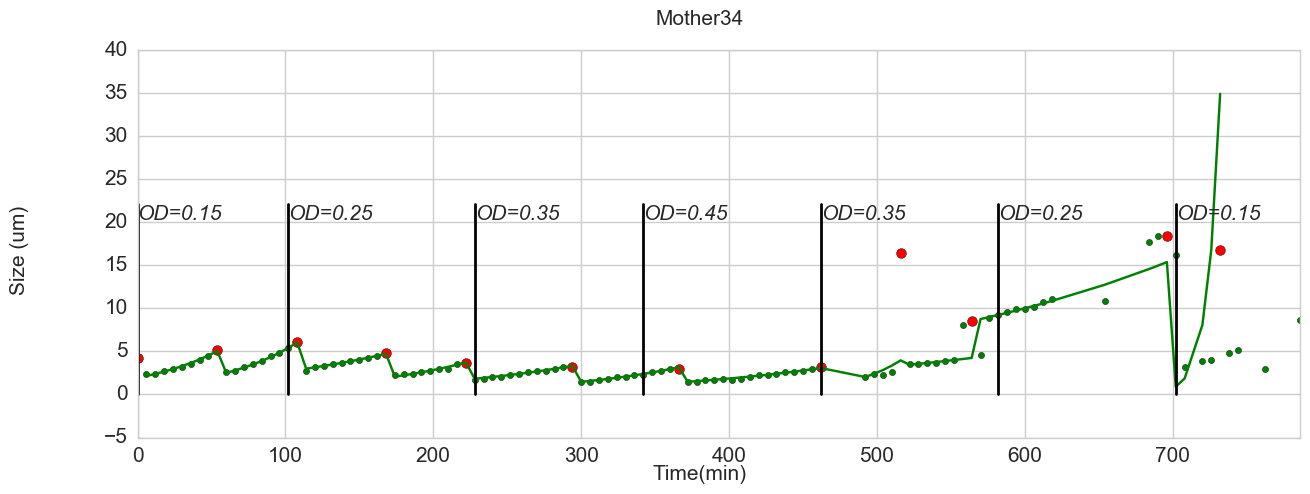

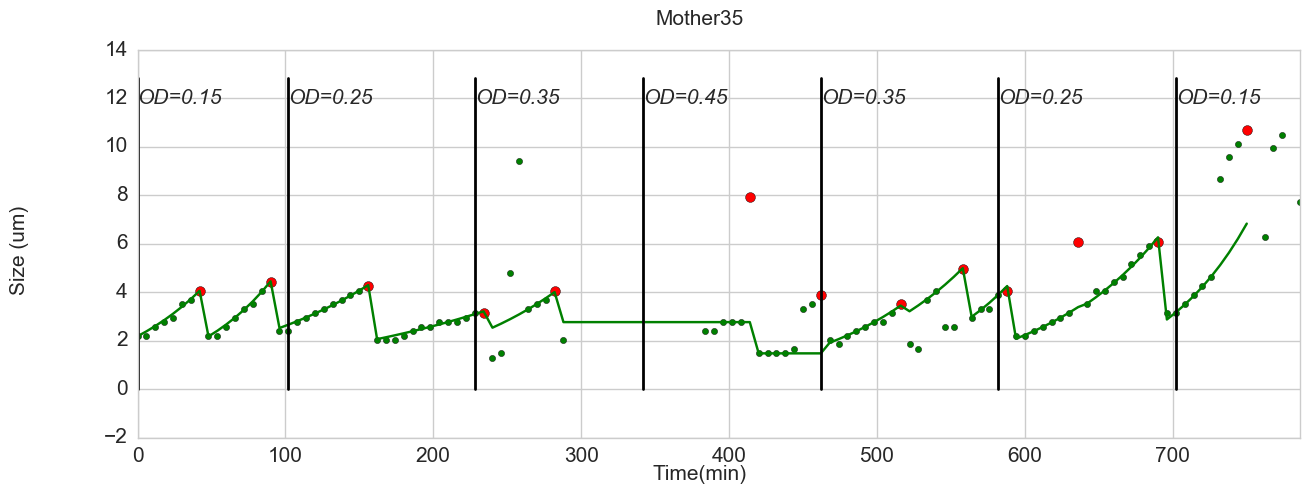

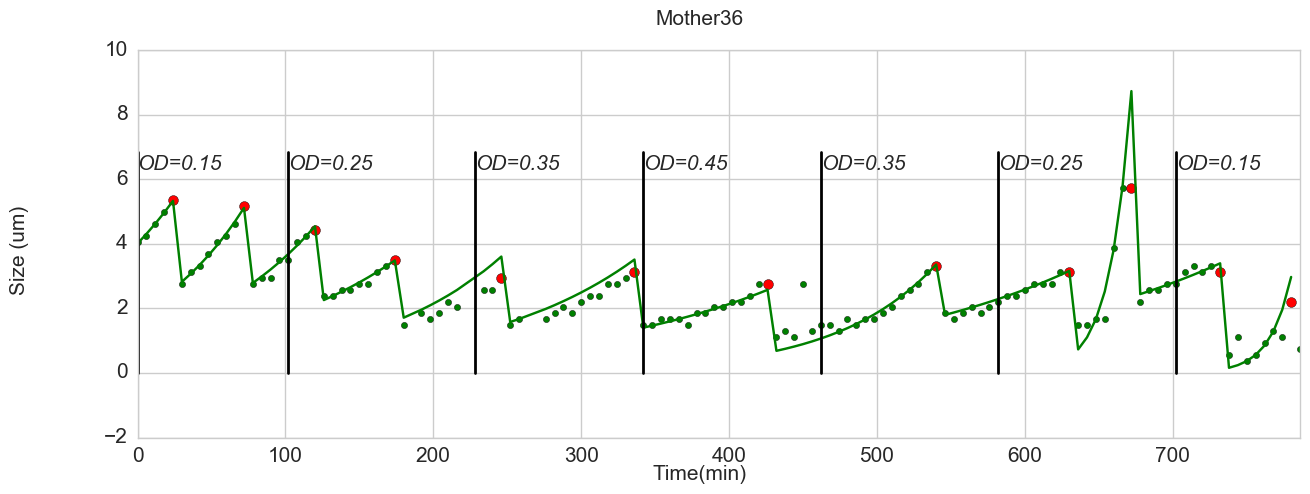

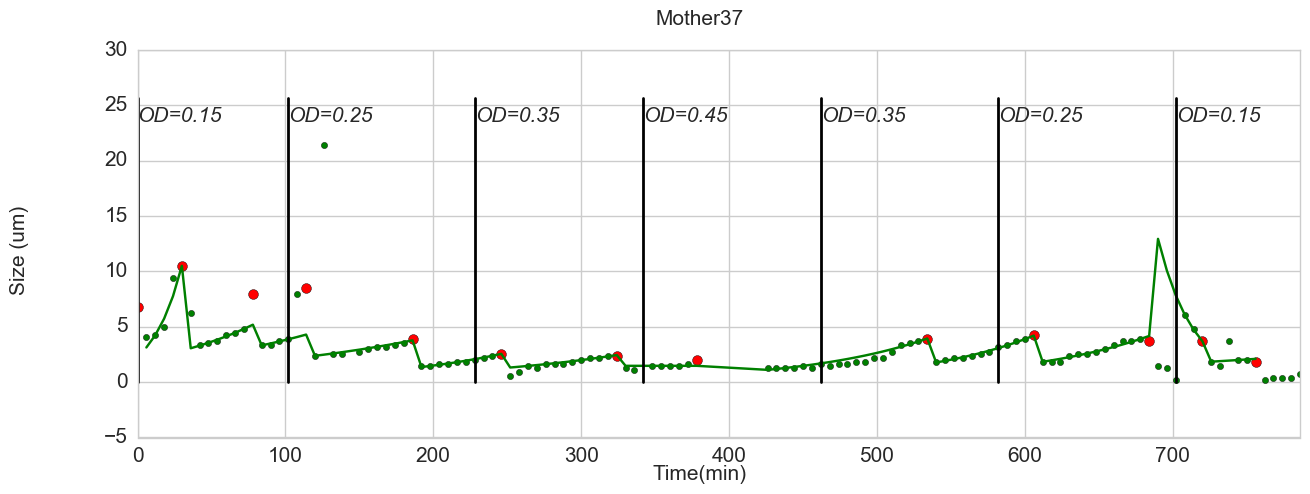

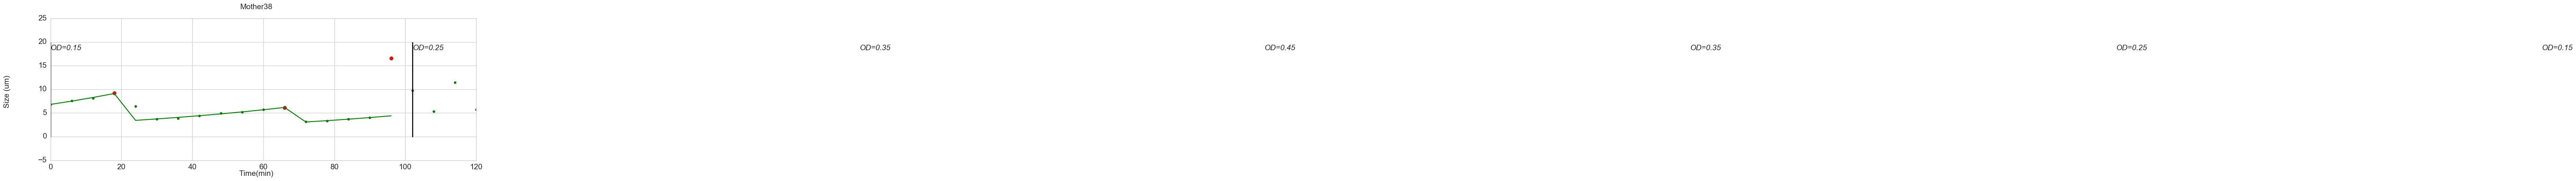

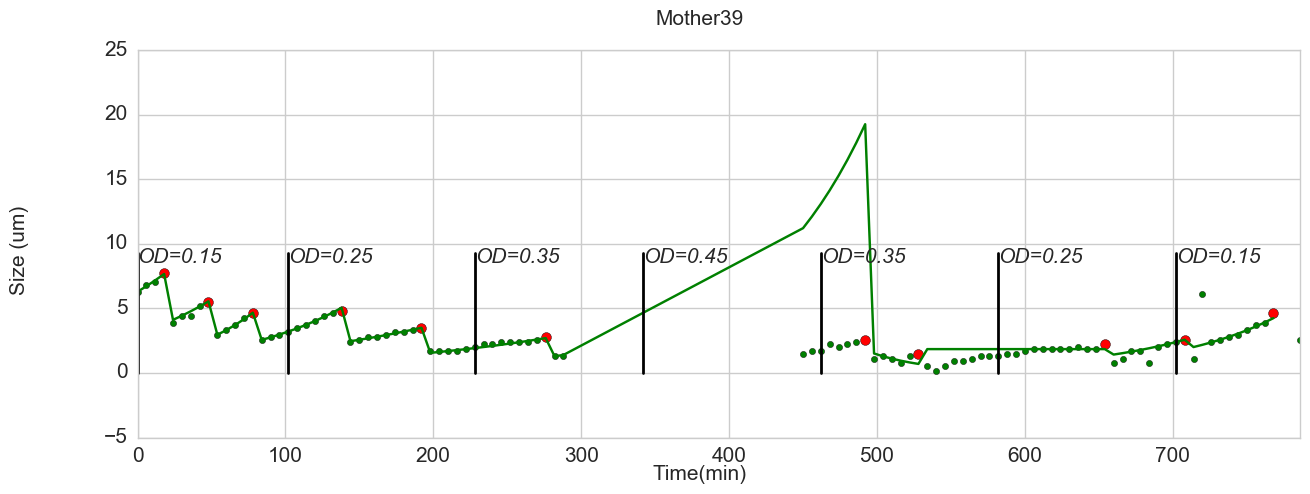

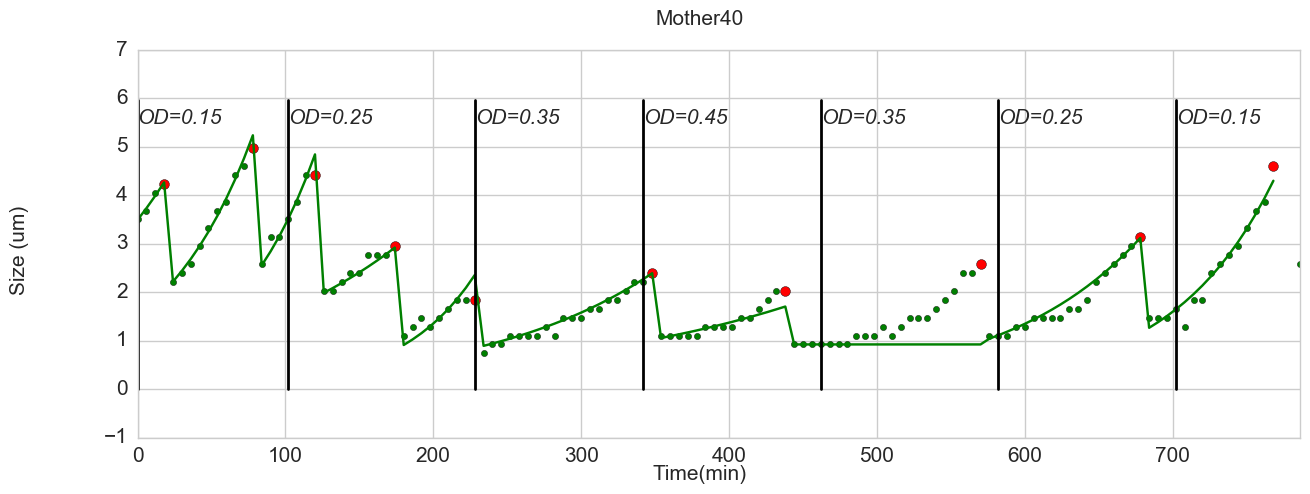

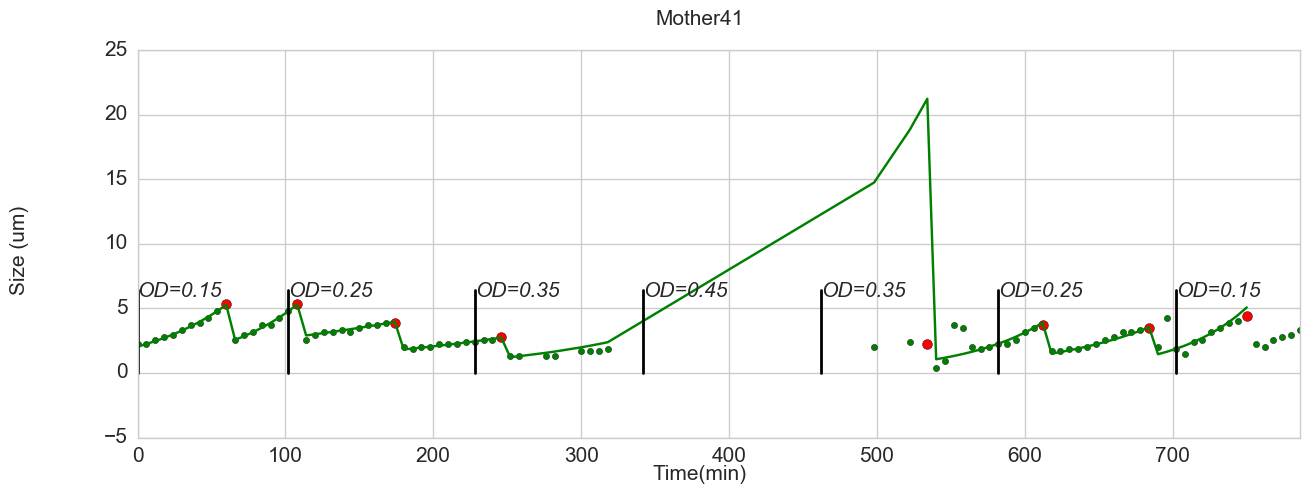

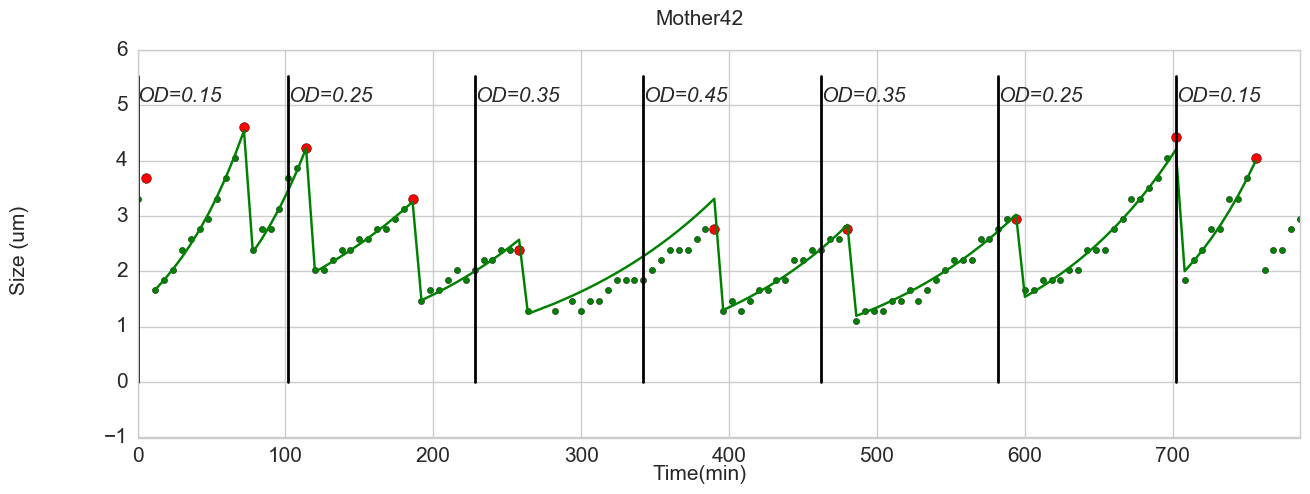

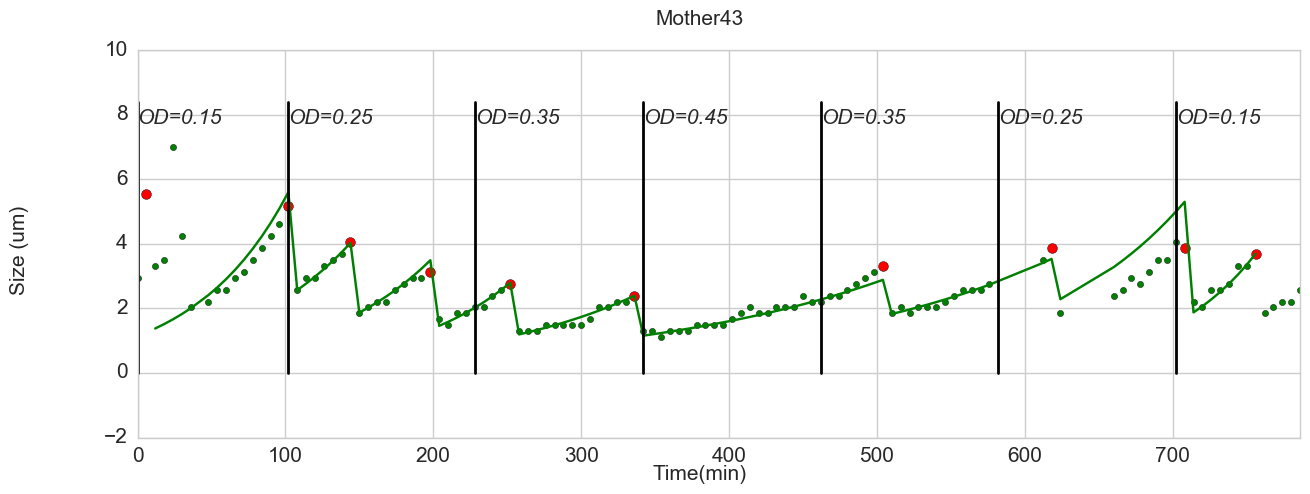

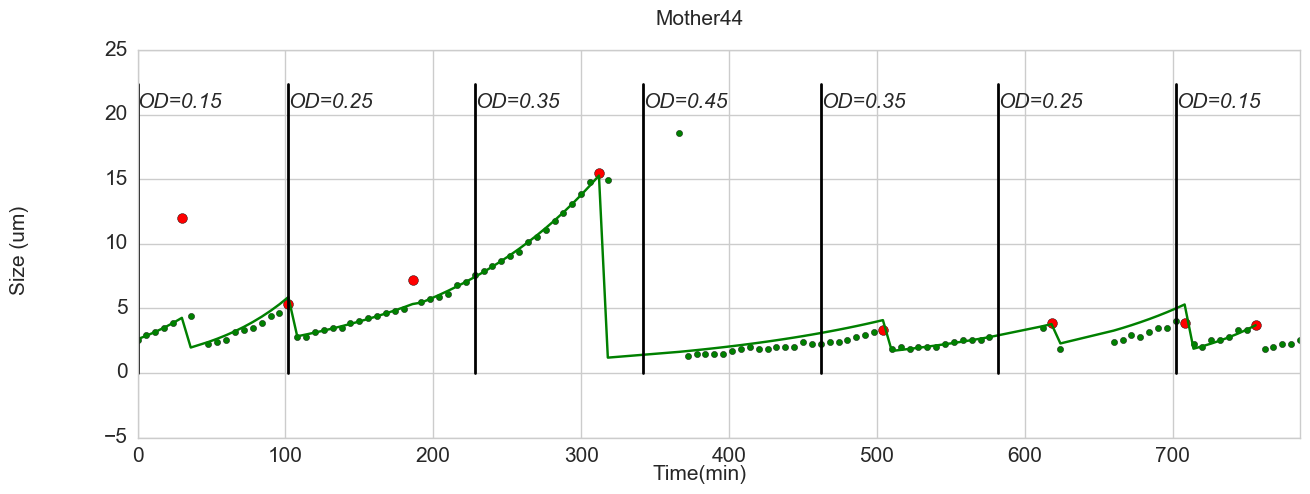

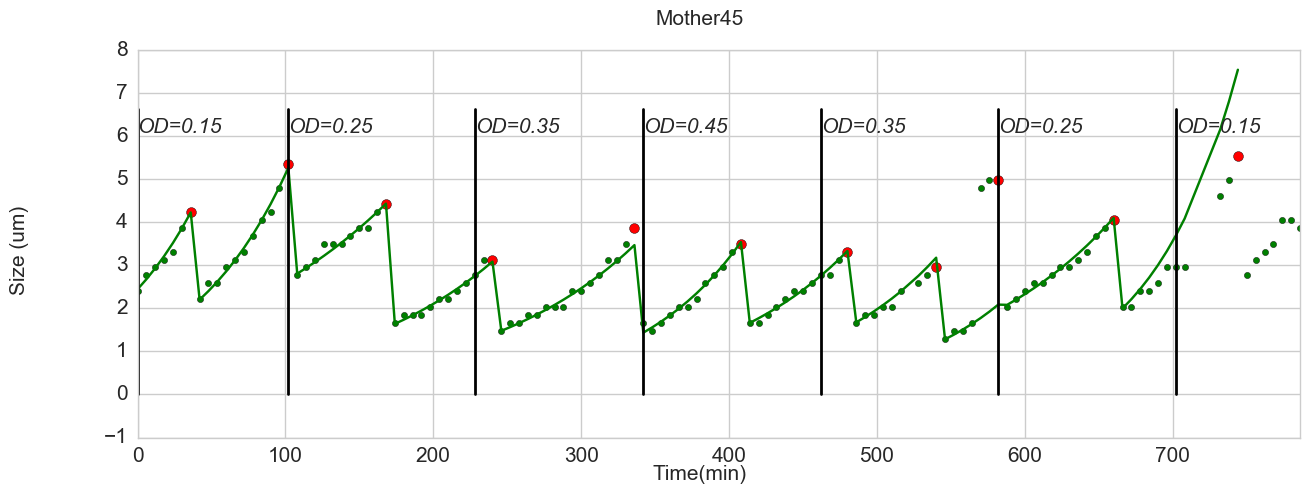

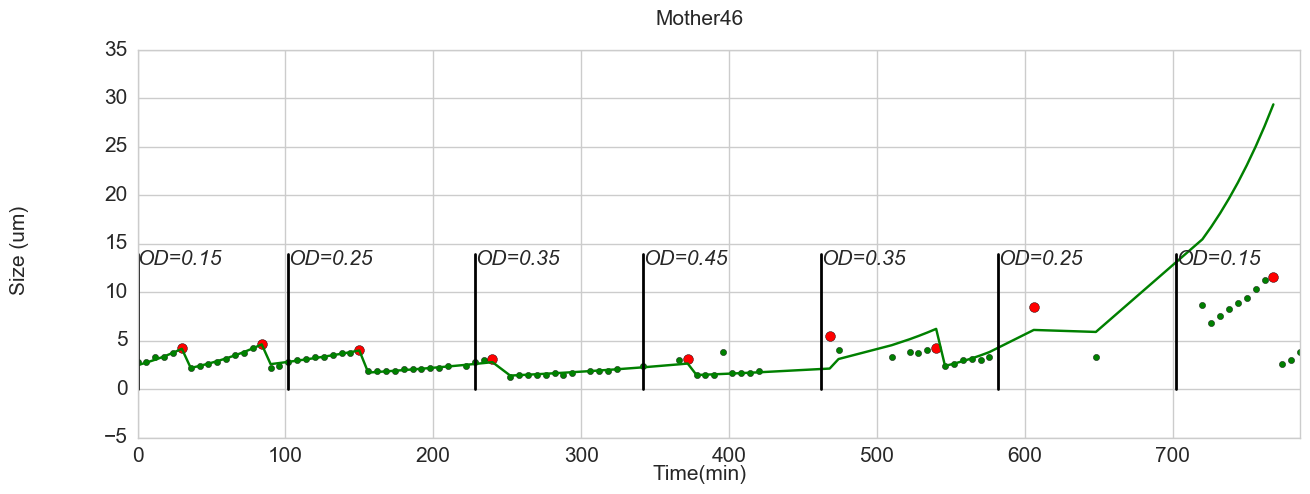

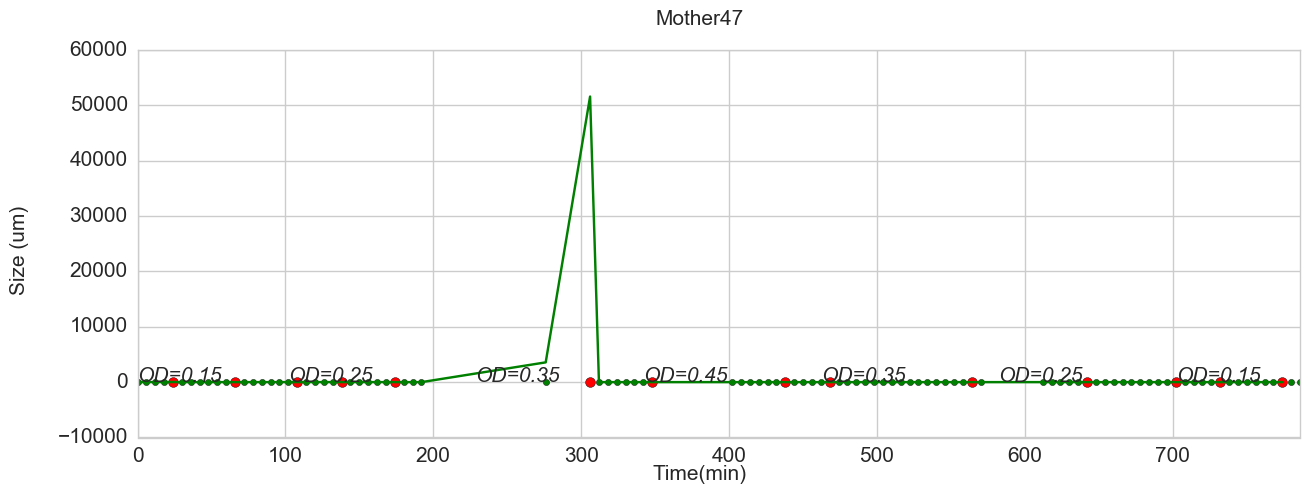

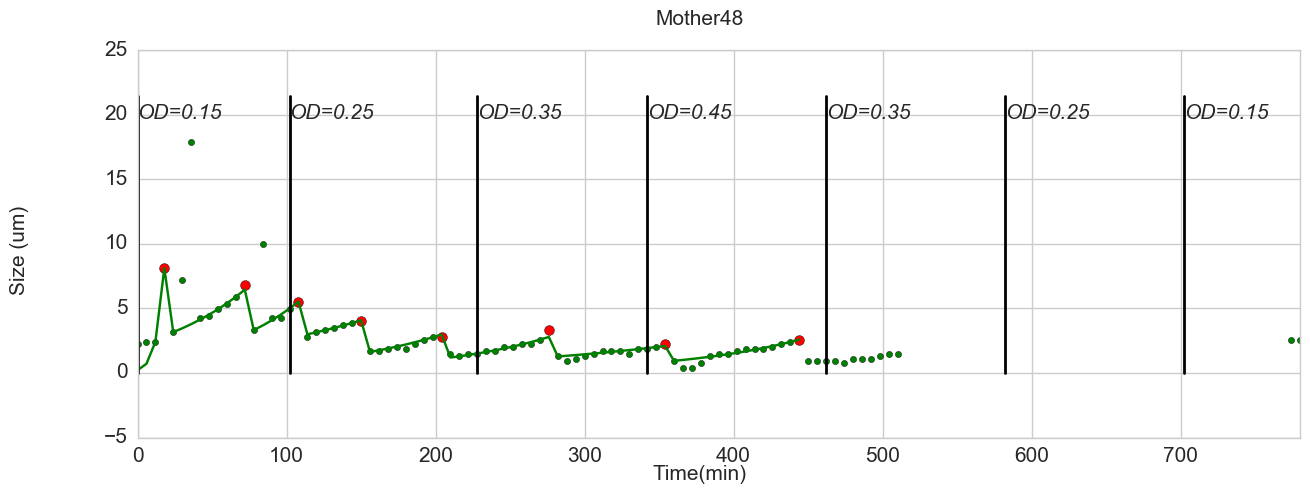

In [33]:
if not os.path.exists('./motherfluor'):
    os.makedirs('./motherfluor')
if not os.path.exists('./motherlen'):
    os.makedirs('./motherlen')   
motherarray = data['Mother'].unique()
totaltime = data['Time(min)'].unique()
motherlen = []
divisiontime = []
td = []

for i in motherarray:
    motherlen.append(data.query('Mother == '+str(i)))
doublings=np.zeros((len(totaltime), len(motherlen)))#number frames, #numbermothers
for i in motherarray:#mothers
    
    ln = motherlen[i]['Length(um)'].tolist()
    
    time = motherlen[i]['Time(min)'].tolist()
    lmax =[]
    lmin=[]

    timebetweenframes=time[2]-time[1]
    ind = indexes(ln,thresh, peakdist)
    tind=np.zeros(len(ind))
    fitl=[]
    fitt=[]
    for j in range(len(ind)):#counting over all peaks
        tind[j]=time[ind[j]]
        lmax.append(ln[ind[j]])
        lmin.append(ln[ind[j]+1])
        if(j>0):
            d=float(time[ind[j]]-time[ind[j-1]])#division time
            tt=ind[j-1]+1#initial time for ransac estimation
        else:
            d=float(time[ind[j]]-time[0])
            tt=0
        dt=[]#array of log(len)
        tm=[]
        results=[]
        temp=0
        while(tt<=ind[j]):
            dt.append(np.log2(ln[tt]))
            tm.append(temp)
            temp=temp+timebetweenframes
            tt=tt+1
        if(len(dt)>2):#guarantees there is enought data
            tm = np.array(tm).reshape((len(tm), 1))#converting a row into a column
            model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=0.05)
            model_ransac.fit(tm, dt)#smart fit
            a=model_ransac.estimator_.coef_#growth rate
            divisiontime.append(d)
            td.append([a,d])
            l0=2**(model_ransac.estimator_.intercept_)
            if(j>0):
                tt=ind[j-1]+1#temporaltime
                while(tt<=ind[j]):
                    doublings[tt][i] = a[0]
                    fitl.append(l0*2**((-time[ind[j-1]+1]+time[tt])*a[0]))
                    fitt.append(time[tt])
                    tt=tt+1   
            else:
                tt=0 
                while(tt<=ind[j]):
                    doublings[tt][i] = a[0]
                    fitl.append(l0*2**(time[tt]*a[0]))
                    fitt.append(time[tt])
                    tt=tt+1 
    fig, ax = plt.subplots(1, 1, figsize=(15, 5),sharex=True)
    setplot('Time(min)','Size (um)')
    ax.plot(fitt,fitl,c = 'g')
    ax.scatter(time,ln,c = 'g',s = 20)
    y=[0]*len(tind)
    ax.scatter(tind,lmax, c='r', s=50 )
    ax.set_xlim([time[0], time[len(time)-1]])
    for m in range(len(ref)):
        ax.plot([ref[m], ref[m]], [0,1.2*np.max(ln)], 'k-', lw=2)
        ax.text(ref[m], 1.1*np.max(ln), annotation[m], style='italic',fontsize=15)    
    #ax.set_ylim([0,15])
    fig.suptitle('Mother' + str(i),fontsize=15)
    plt.savefig('./motherlen/mother'+str(i)+'.png')
    

## Average doubing time dynamics

In [34]:
mediangr=np.zeros(len(doublings))#len of frames
std=np.zeros(len(doublings))
for k in range(len(doublings)):#frames
    temp=[]
    for j in range (len(doublings[k])):#madres
        if(doublings[k][j] != 0.0):
            temp.append(doublings[k][j])        
    if(len(temp)>1):            
        mediangr[k]=np.median(temp)
        for l in range (len(temp)):
            stt=abs(temp[l]-mediangr[l])
            if(stt<mediangr[k]):
                std[k]+=stt/len(temp)

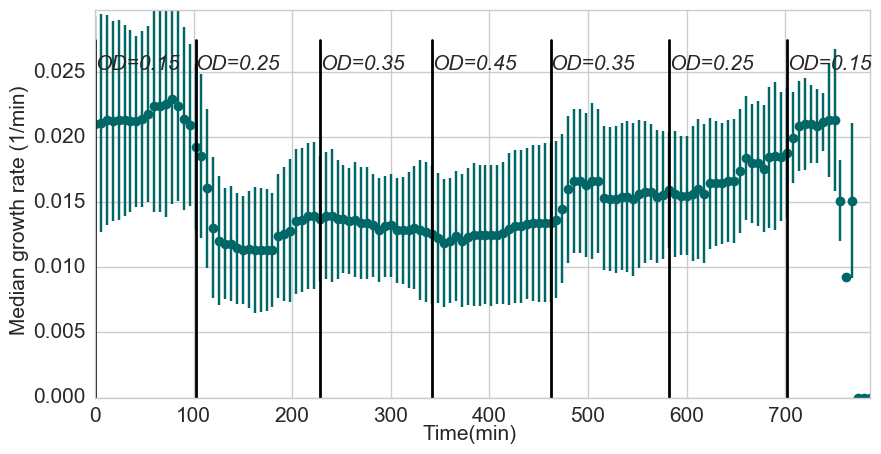

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=True)
setplot('Time(min)','Median growth rate (1/min)')
ax.errorbar(totaltime, mediangr, yerr=std, fmt='o',c='#006666')
ax.set_ylim([0,1.3*np.max(mediangr)])
ax.set_xlim([totaltime[0], totaltime[len(totaltime)-1]])
for m in range(len(ref)):
    ax.plot([ref[m], ref[m]], [0,1.2*np.max(mediangr)], 'k-', lw=2)
    ax.text(ref[m], 1.1*np.max(mediangr), annotation[m], style='italic',fontsize=15)
plt.savefig('doublingtime.png')
f = open("./doublingtime.csv", "w")#Opens and then closes the file in order to erase all previous values
f.close()
f = open("./doublingtime.csv", "w")#opens the empty file 
f.write("time(min),Mediangrowtrate"+"\n")
for j in range (len(time)):
    f.write(str(totaltime[j])+","+str(mediangr[j])+"\n")
f.close()

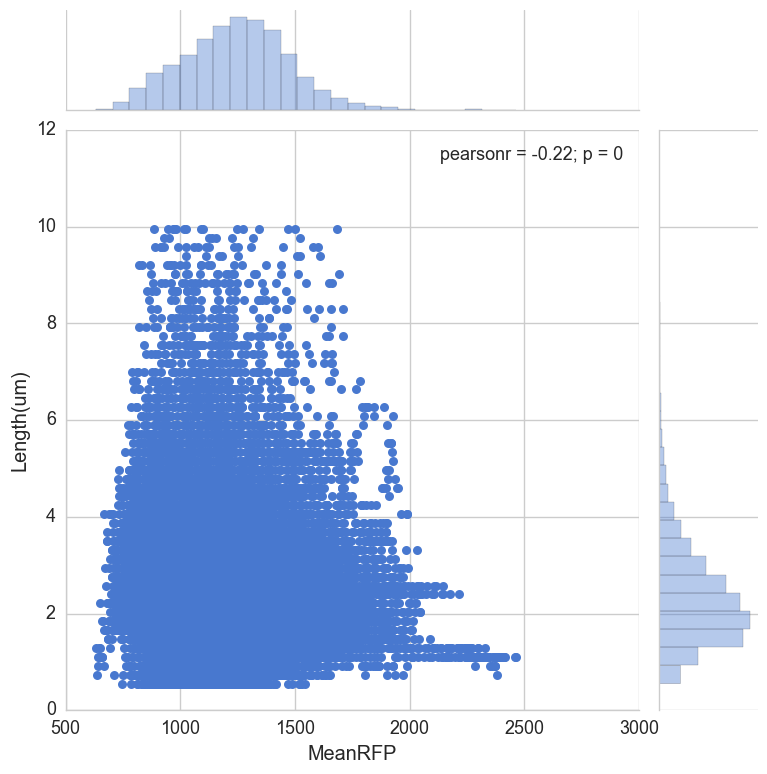

In [43]:
if not os.path.exists('./jointplot'):
    os.makedirs('./jointplot')
sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
plot = sns.jointplot('MeanRFP','Length(um)',alldf,size=8,linewidth=2,marginal_kws=dict(bins=25))
plot.savefig('./jointplot/name')

In [107]:
if (GFPimages):  
    data = pd.read_csv("AllCellData.csv")
    getjointplot('MeanGFP','Length(um)',data,'totalGFPvslength.png')
else:
    print('there is no GFP in your data')

there is no GFP in your data


C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


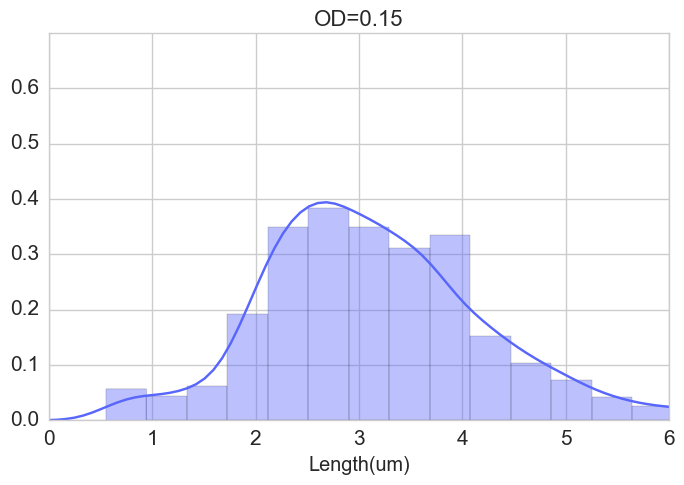

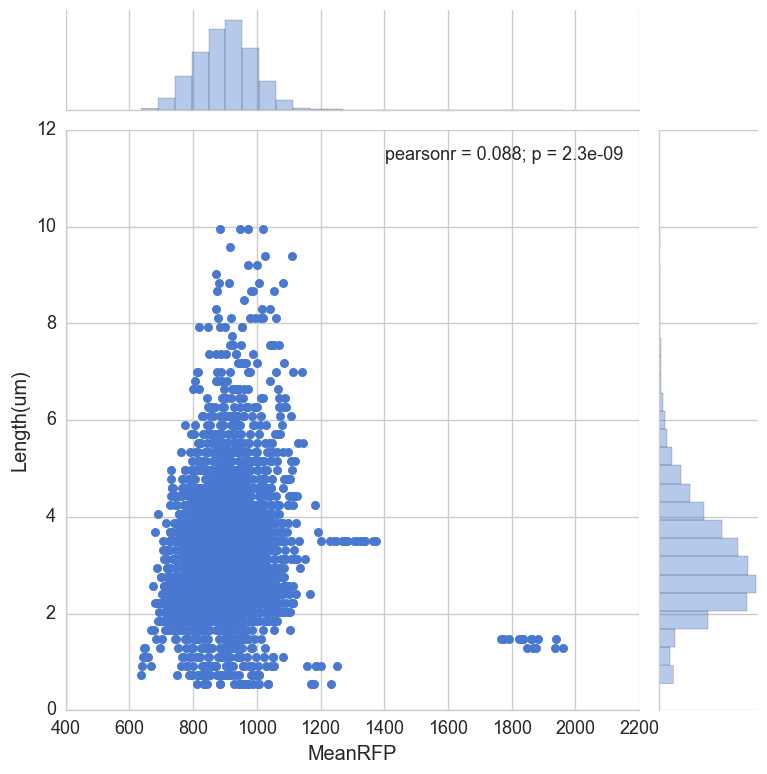

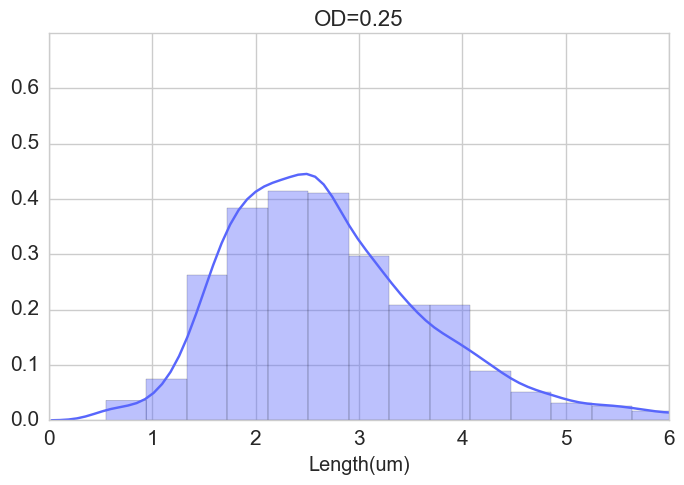

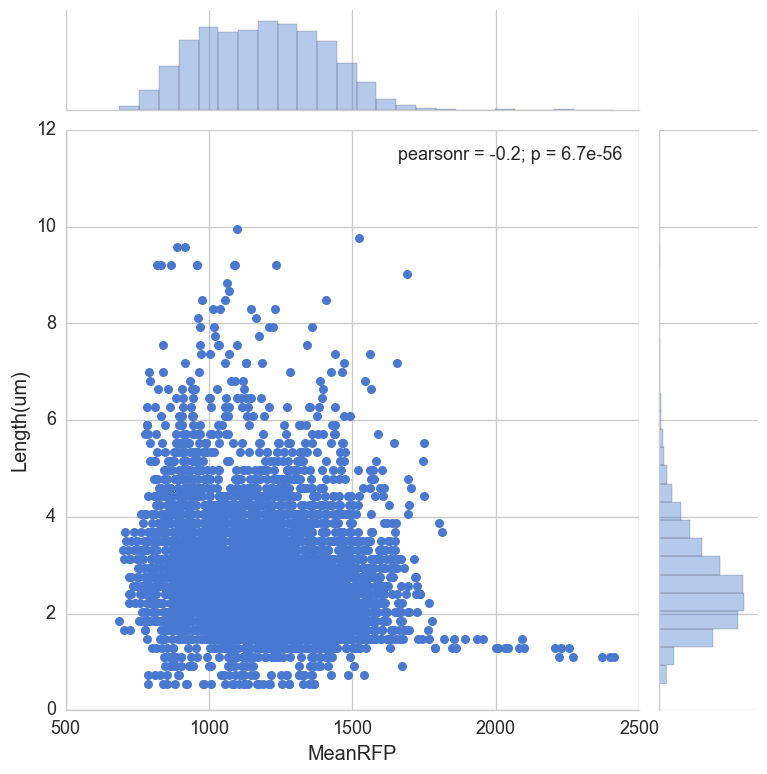

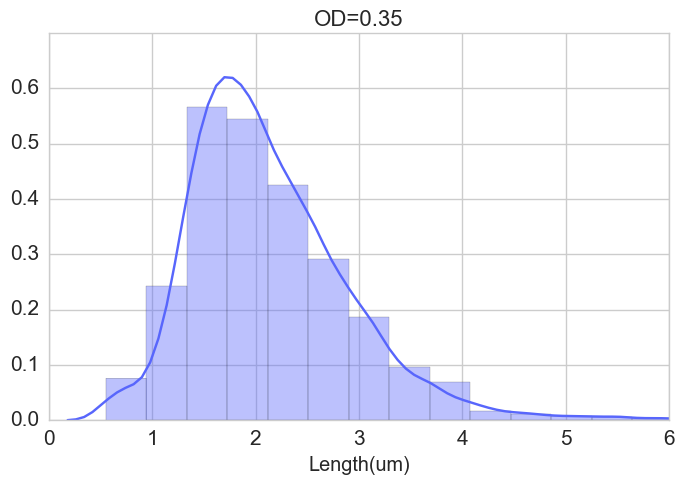

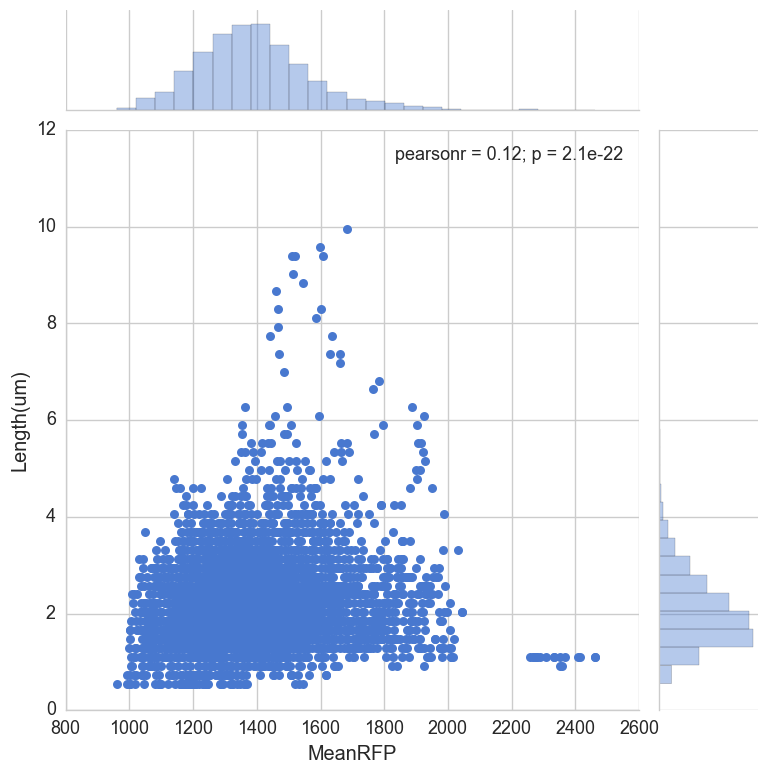

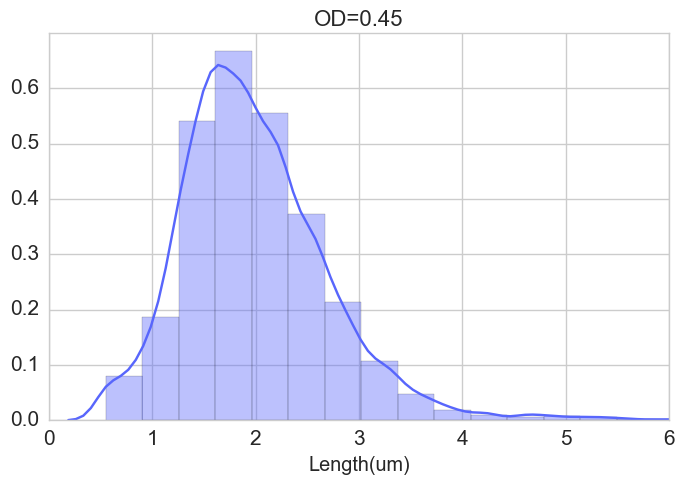

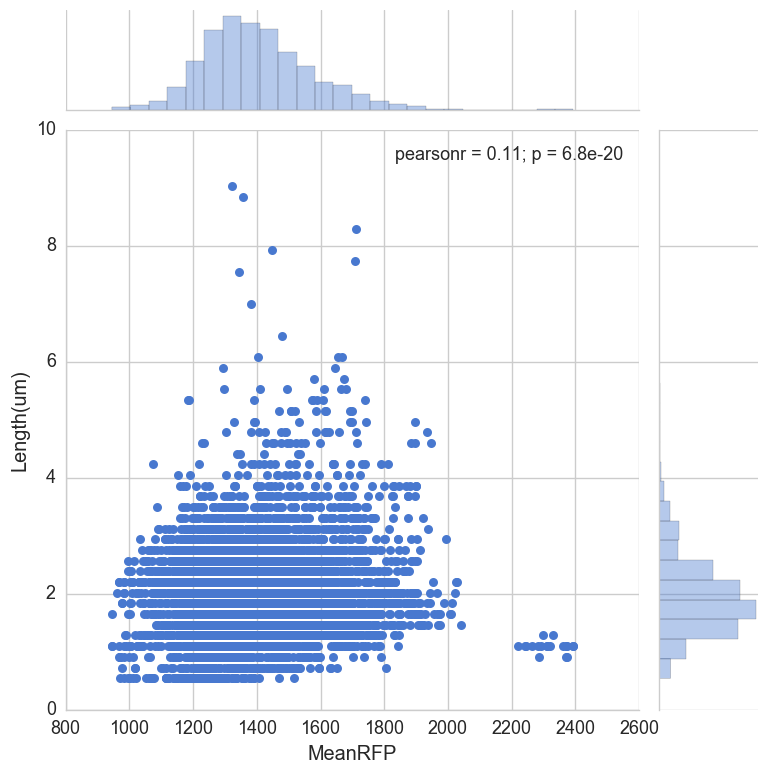

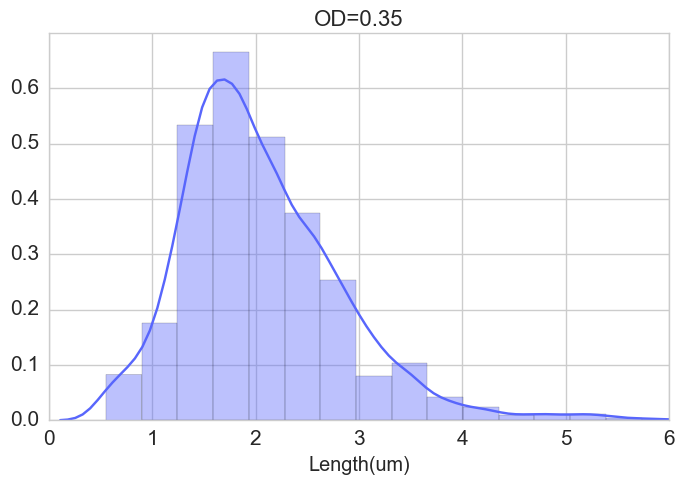

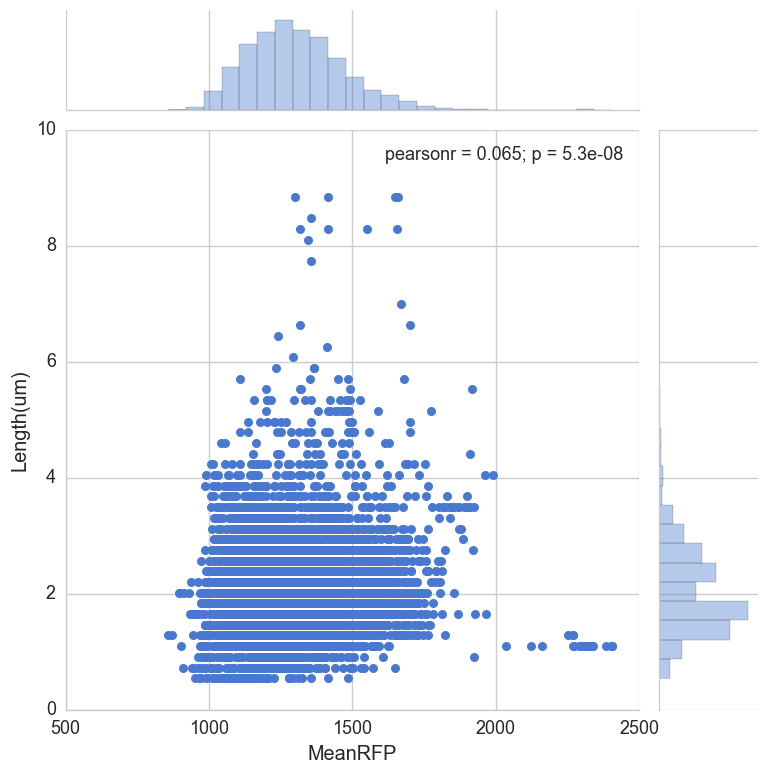

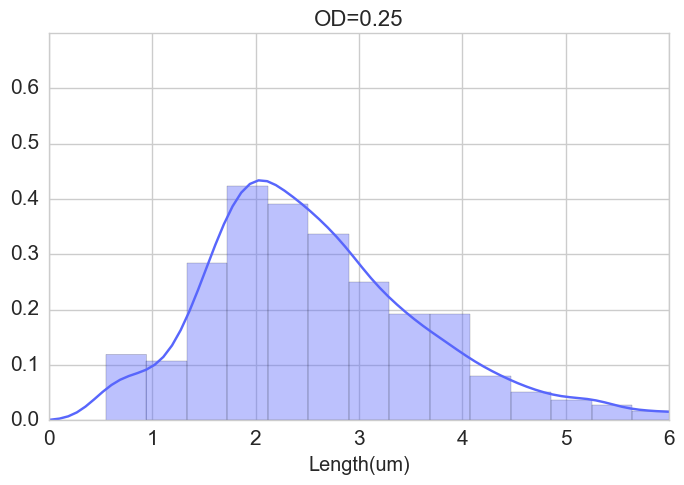

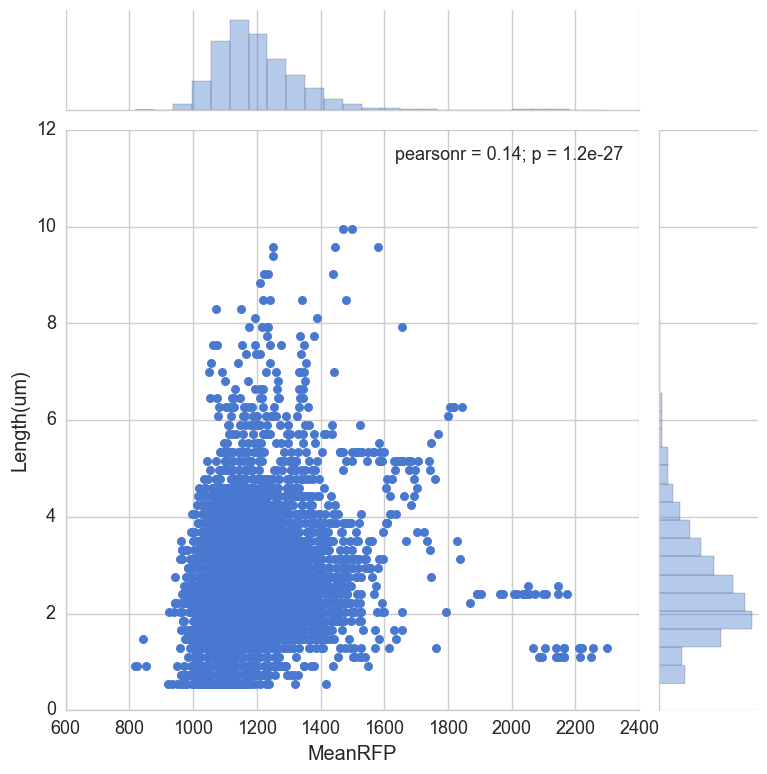

In [13]:

if not os.path.exists('./lendistributions'):
    os.makedirs('./lendistributions')
for i in range (1,len(ref)):
    timex=alldf[alldf['Time(min)'] <ref[i]]
    timex=timex[timex['Time(min)']>ref[i-1]]
    fl = timex['Length(um)'].tolist()
    fl = pd.Series(fl, name="Length(um)")
    fig, ax = plt.subplots(1,1, figsize=(8, 5),sharex=True)
    sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
    sns.distplot(fl,bins=24,color="#5866FC")
    ax.set_ylim([0,0.7])
    ax.set_xlim([0,6])
    ax.set_title(annotation[i-1],fontsize=16)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.figure.savefig('./lendistributions/'+annotation[i-1]+'('+str(ref[i])+'-'+str(ref[i])+').png')
    getjointplot('MeanRFP','Length(um)',timex,'MeanRFPvsLength'+str(annotation[i-1])+'.png')

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


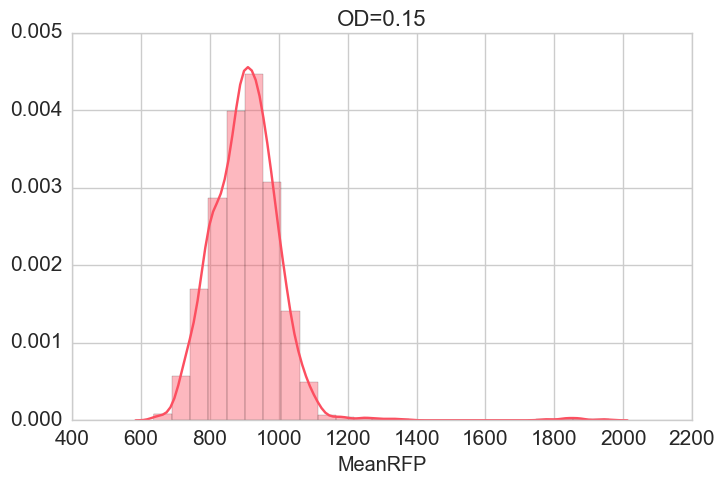

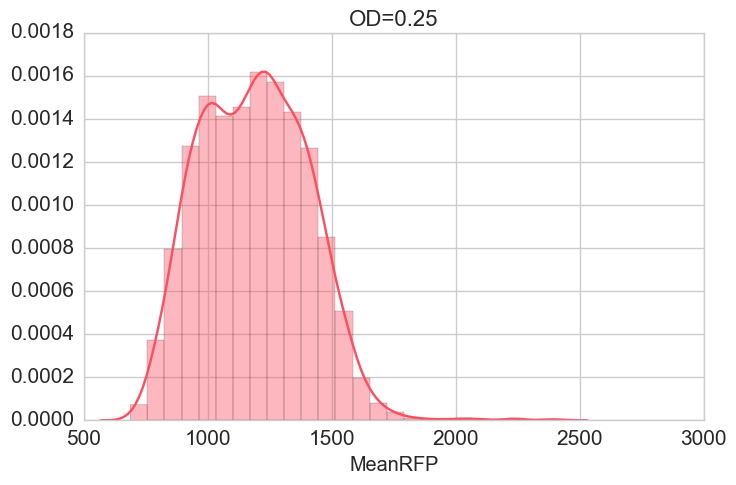

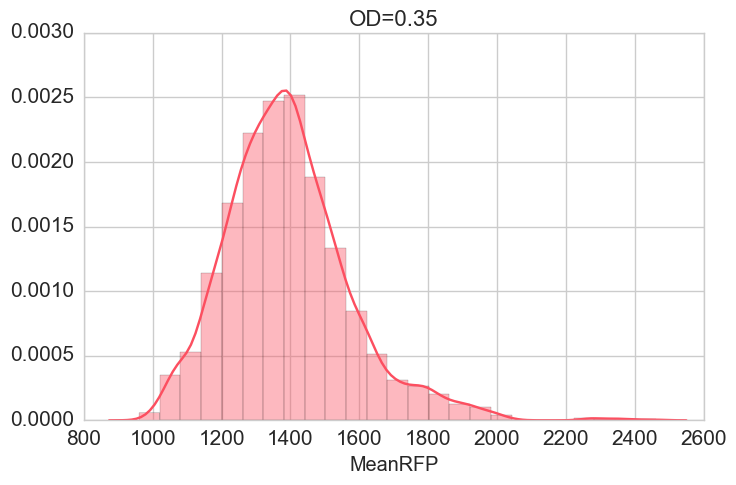

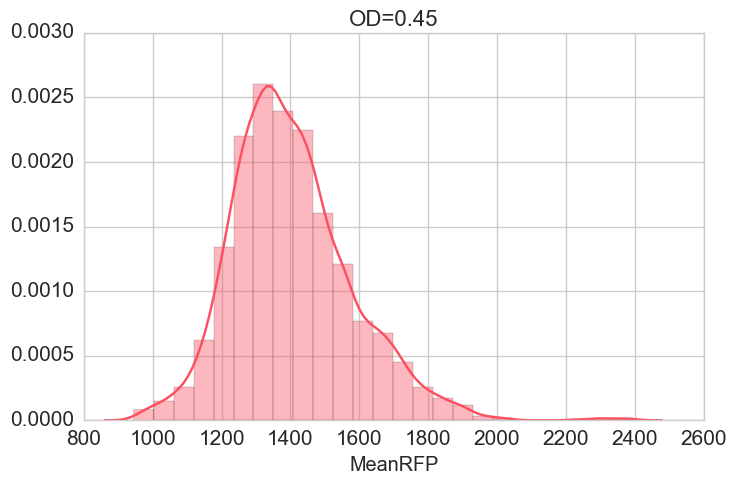

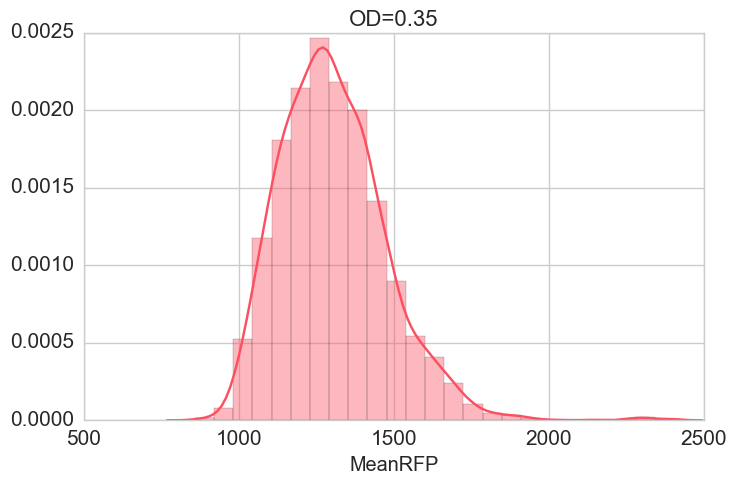

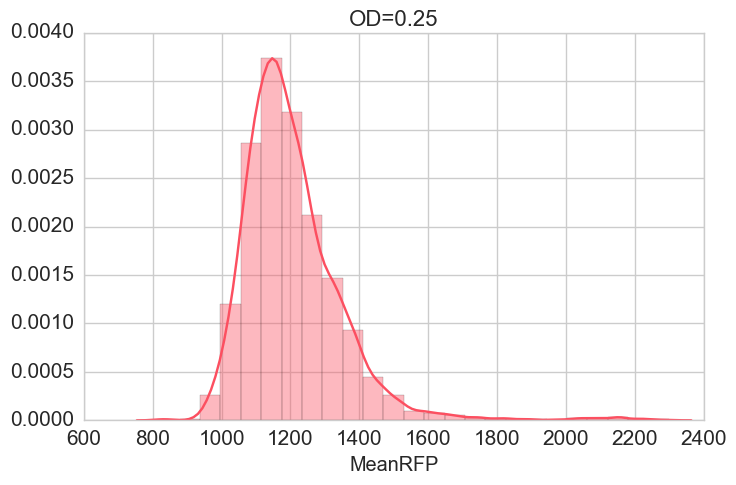

In [14]:
if not os.path.exists('./fluordistributions'):
    os.makedirs('./fluordistributions')
for i in range (1,len(ref)):
    timex=alldf[alldf['Time(min)'] <ref[i]]
    timex=timex[timex['Time(min)']>ref[i-1]]
    fl = timex['MeanRFP'].tolist()
    flR= pd.Series(fl, name="MeanRFP")
    fig, ax = plt.subplots(1, 1, figsize=(8, 5),sharex=True)
    sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
    sns.distplot(flR,bins=25,color="#FC4F60")
    ax.set_title(annotation[i-1],fontsize=16)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    plt.savefig('./fluordistributions/RFP'+annotation[i-1]+'('+str(ref[i])+'-'+str(ref[i])+').png')
    if(GFPimages):
        fig, ax = plt.subplots(1, 1, figsize=(8, 5),sharex=True)
        sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)
        sns.distplot(flG,bins=25,color="#0DA102")
        ax.set_title(str(annotation[i-1]),fontsize=16)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
        plt.savefig('./fluordistributions/GFP'+annotation[i-1]+'('+str(ref[i])+'-'+str(ref[i])+').png')

## Mother fluorescence ploting

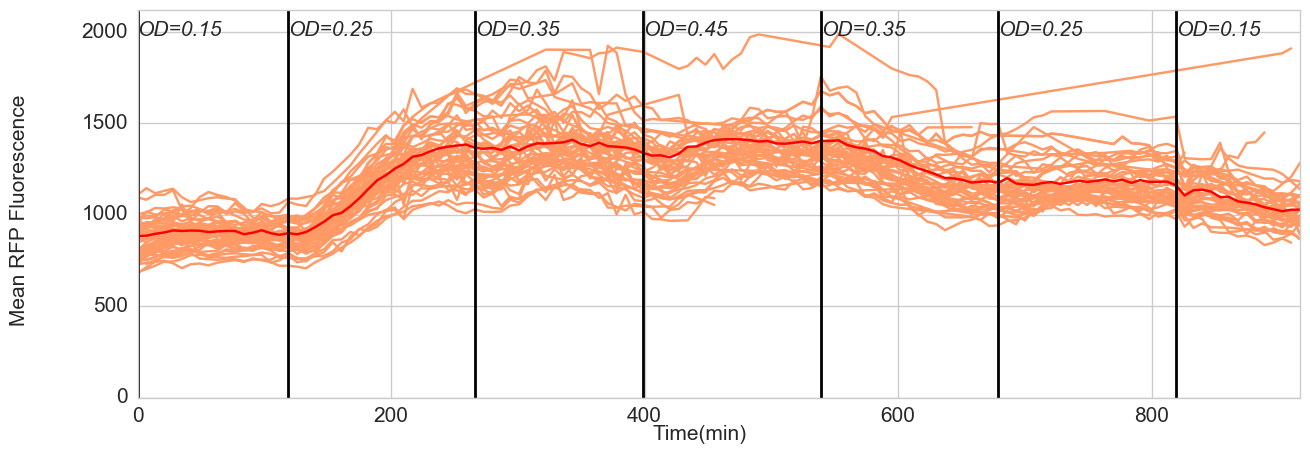

In [17]:
if not os.path.exists('./fluorstatistics'):
    os.makedirs('./fluorstatistics')

frames = alldf['Frame'].unique()
cells=[]
rfpfl=[]
noiserfp = []
avetime = []
for i in frames:#taking all data withs same frame
    cells.append(alldf.query('Frame ==  '+str(i)))
for i in frames:#computing RFP average for all population in each frame
    fluors = cells[i]['MeanRFP'].tolist()
    avetime.append(i*timebetweenframes)
    rfpfl.append(np.median(fluors))
    noiserfp.append(np.std(fluors)/np.median(fluors))
#geting all mother rfp fluorescense

motherarray = data['Mother'].unique()
motherfl = []
fig, ax = plt.subplots(1,1, figsize=(15, 5))
setplot('Time(min)','Mean RFP Fluorescence')

for i in motherarray:
    motherfl=data.query('Mother == '+str(i))
    rfl = motherfl['MeanRFP'].tolist()
    timef = motherfl['Time(min)'].tolist()
    ax.plot(timef,rfl,c = '#ff9966')
ax.set_xlim([timef[0], timef[len(timef)-1]])
ax.plot(avetime,rfpfl,c = 'r')
ax.set_xlim([avetime[0], avetime[len(avetime)-1]])
ax.set_ylim(0, 1.5*np.max(rfpfl))
for m in range(len(ref)):
    ax.plot([ref[m], ref[m]], [0,1.5*np.max(rfpfl)], 'k-', lw=2)
    ax.text(ref[m], 1.4*np.max(rfpfl), annotation[m], style='italic',fontsize=15)
plt.savefig('./fluorstatistics/fluorescenseRFP.png')
if(GFPimages):
    for i in frames:#computing GFP average for all population in each frame
        fluorsG = cells[i]['MeanGFP'].tolist()
        gfpfl.append(np.median(fluorsG))
        noisegfp.append(np.std(fluorsG)/np.median(fluorsG))
#geting all mother gfp fluorescense
    fig, ax = plt.subplots(1,1, figsize=(15, 5))
    setplot('Time(min)','Mean GFP Fluorescence')
    for i in motherarray:
        motherfl=data.query('Mother == '+str(i))
        gfl = motherfl['MeanGFP'].tolist()
        timef = motherfl['Time(min)'].tolist()
        ax.plot(timef,gfl,c = '#0DA102')
    ax.plot(timef,gfpfl,c = 'r')
    ax.set_xlim([timef[0], timef[len(timef)-1]])
    ax.set_ylim(0, 1.5*np.max(gfpfl))
    for m in range(len(ref)):
        ax.plot([ref[m], ref[m]], [0,1.5*np.max(gfpfl)], 'k-', lw=2)
        ax.text(ref[m], 1.4*np.max(gfpfl), annotation[m], style='italic',fontsize=15)
    plt.savefig('./fluorstatistics/fluorescenseGFP.png')    

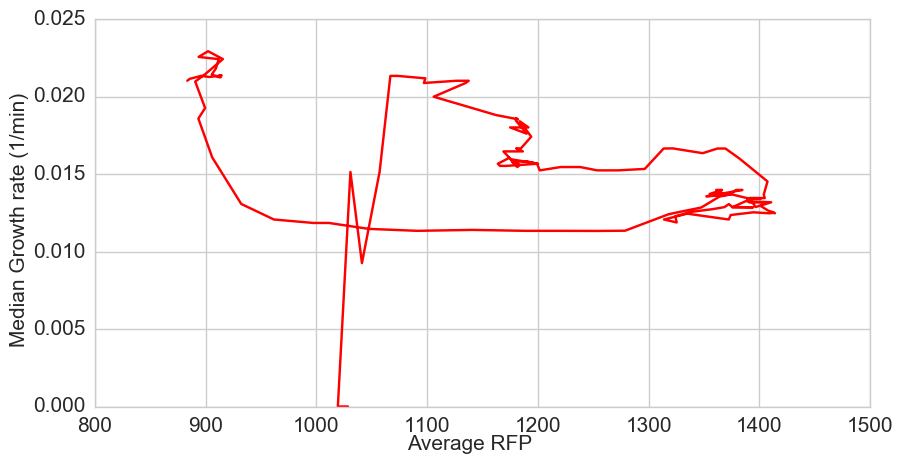

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=True)
setplot('Average RFP','Median Growth rate (1/min)')
ax.plot(rfpfl, mediangr, c='r')
plt.savefig('pathRFP.png')
if(GFPimages):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=True)
    setplot('Average GFP','Median Growth rate (1/min)')
    ax.plot(gfpfl, mediangr, c='r')
    plt.savefig('pathGFP.png')

## Noise Ploting

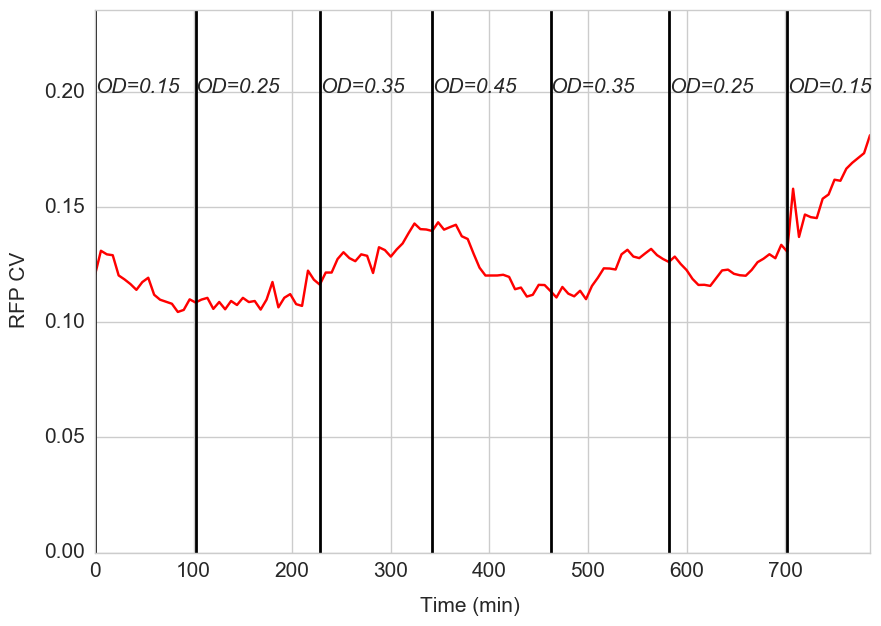

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7),sharex=True)
setplot('Time (min)','RFP CV')
ax.plot(totaltime,noiserfp,c = 'r')

for m in range(len(ref)):
    ax.plot([ref[m], ref[m]], [0,1.3*np.max(noiserfp)], 'k-', lw=2)
    ax.text(ref[m], 1.1*np.max(noiserfp), annotation[m], style='italic',fontsize=15)
ax.set_xlim([totaltime[0], totaltime[len(totaltime)-1]])  
ax.set_ylim([0,1.3*np.max(noiserfp)])
plt.savefig('./fluorstatistics/noiseRFP.png')
if(GFPimages):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7),sharex=True)
    setplot('Time (min)','GFP CV')    
    ax.plot(totaltime,noisegfp,c = 'g')
    for m in range(len(ref)):
        ax.plot([ref[m], ref[m]], [0,1.3*np.max(noisegfp)], 'k-', lw=2)
        ax.text(ref[m], 1.1*np.max(noisegfp), annotation[m], style='italic',fontsize=15)
    ax.set_xlim([totaltime[0], totaltime[len(totaltime)-1]])  
    ax.set_ylim([0,1.3*np.max(noisegfp)])
    plt.savefig('./fluorstatistics/noiseGFP.png')    
    

## sister correlation

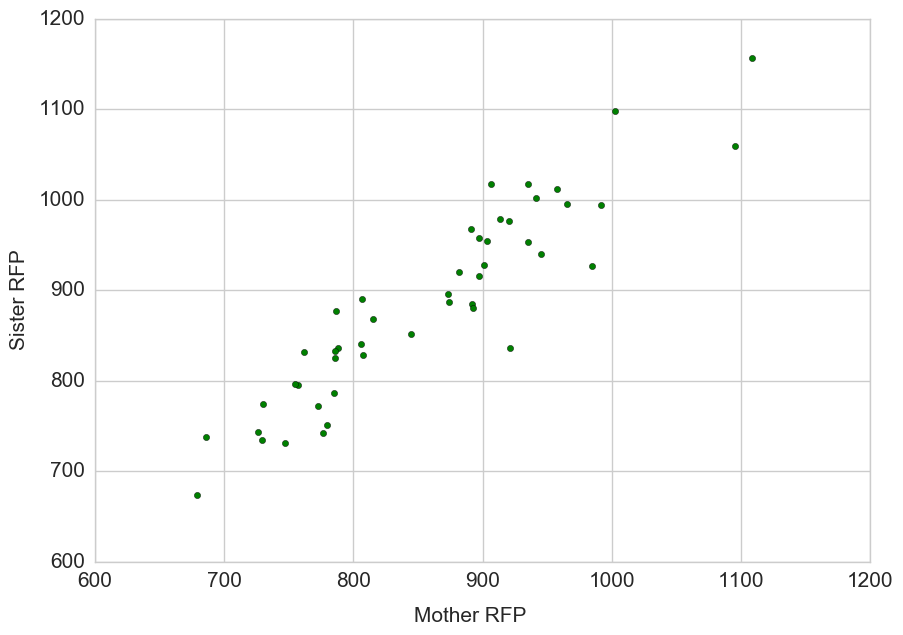

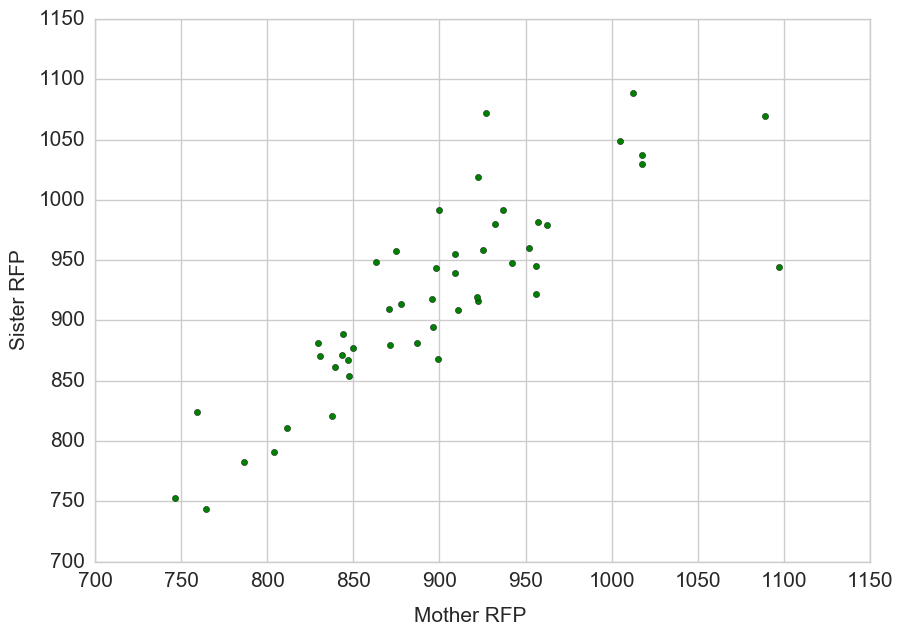

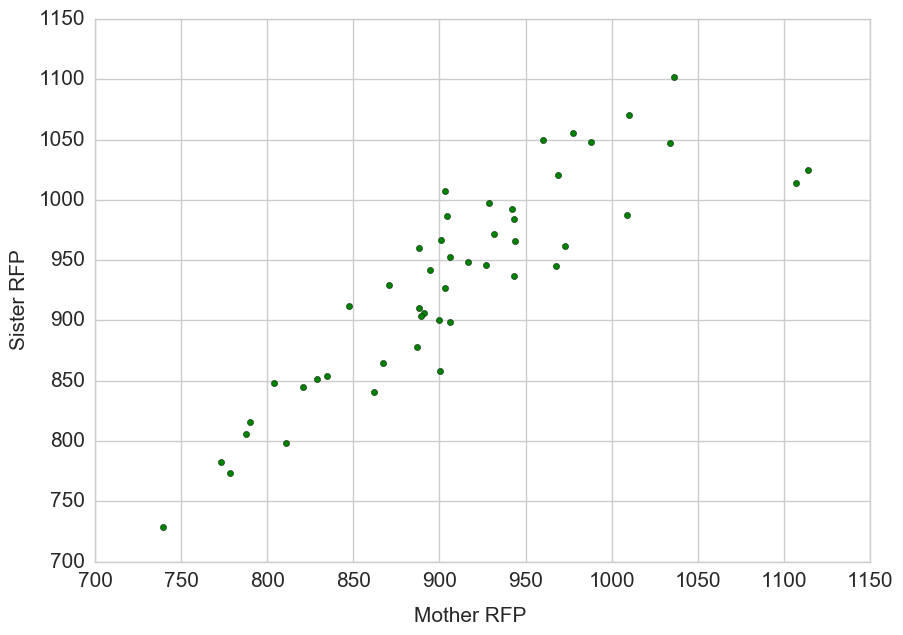

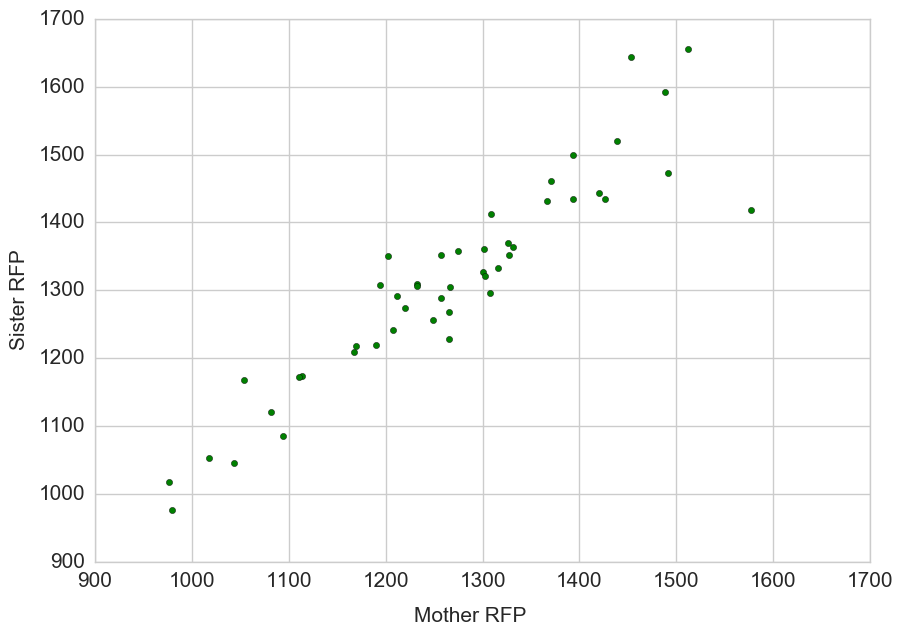

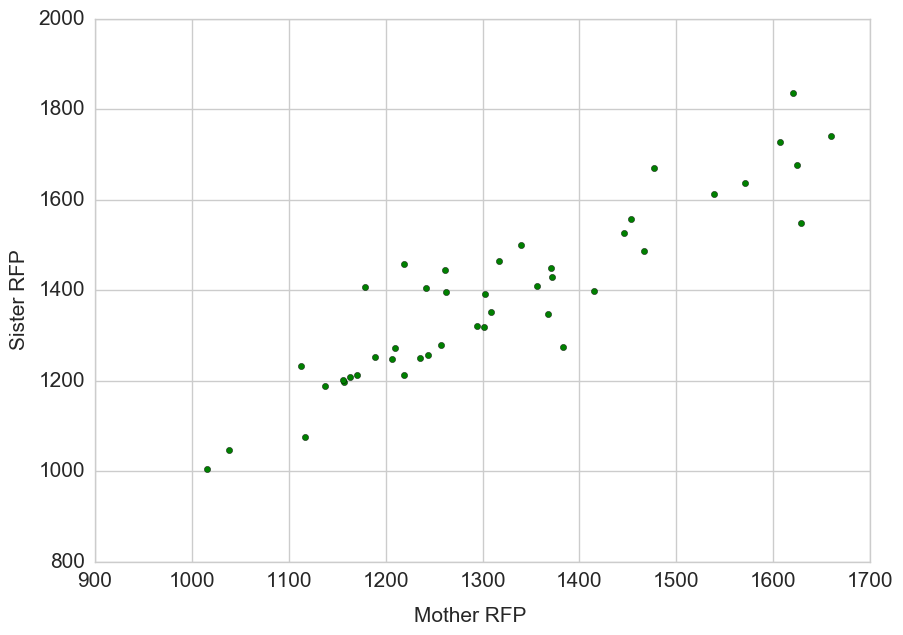

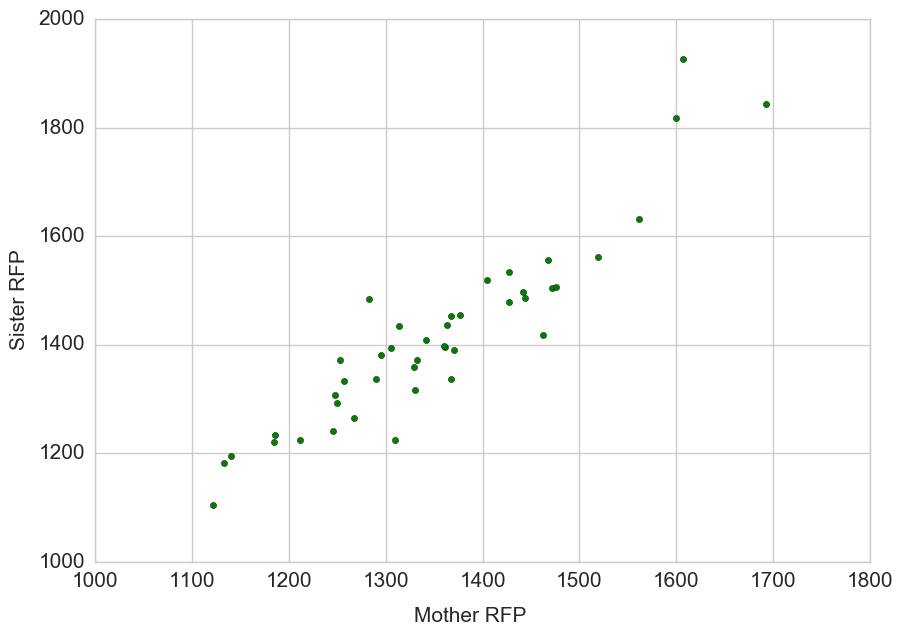

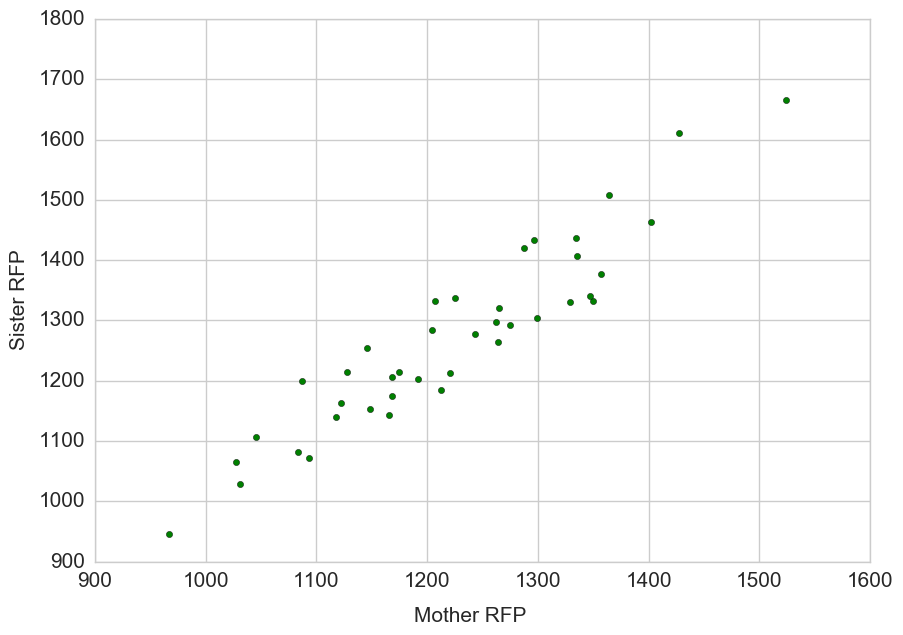

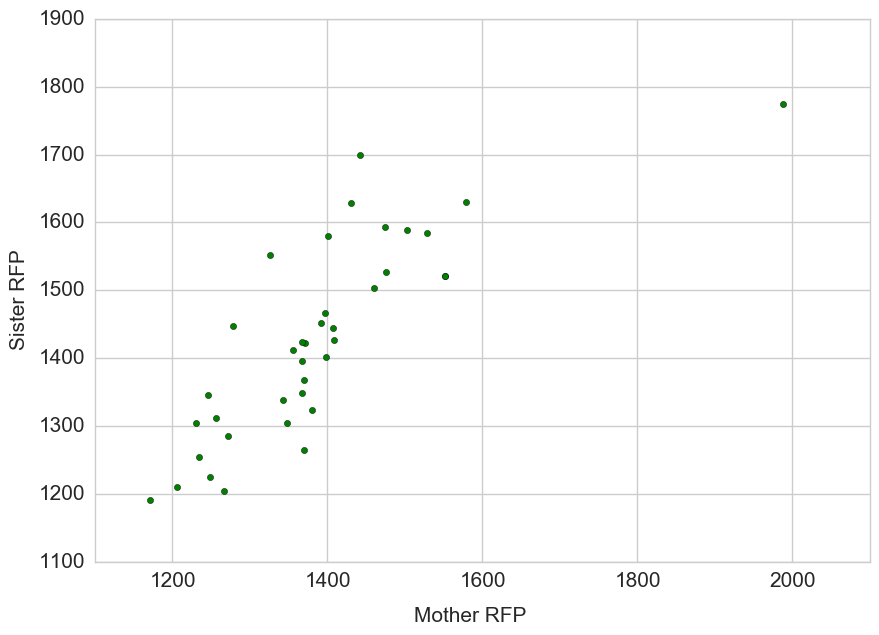

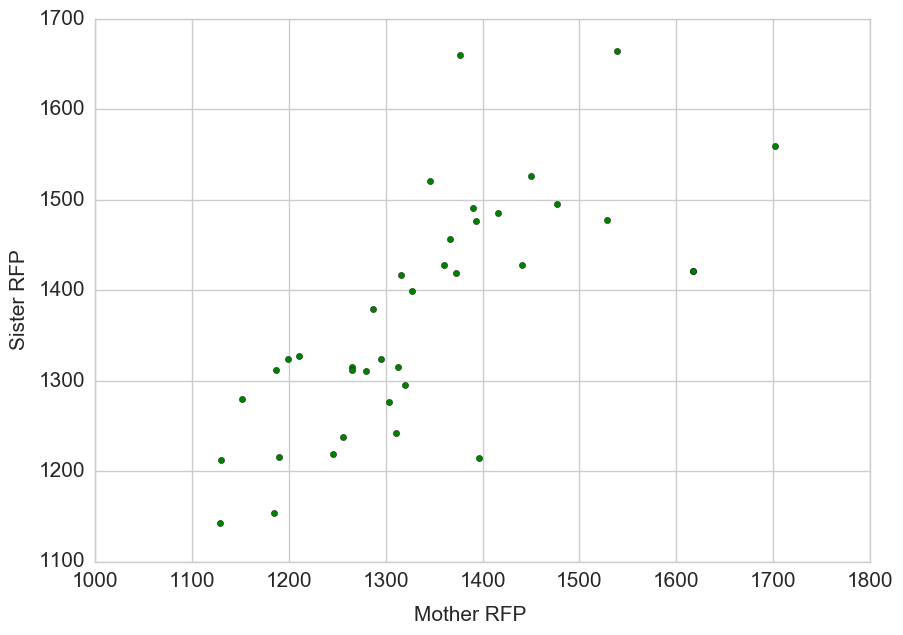

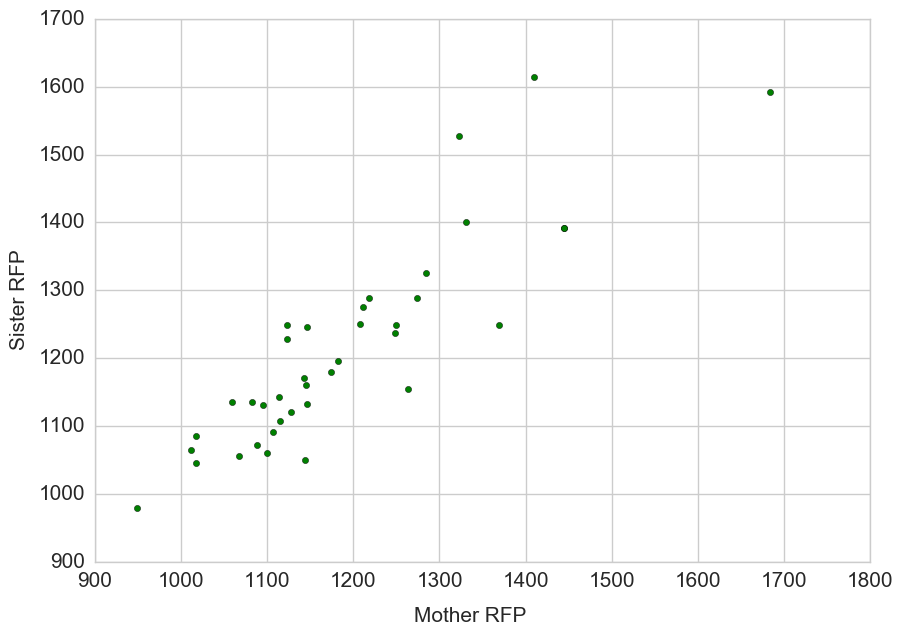

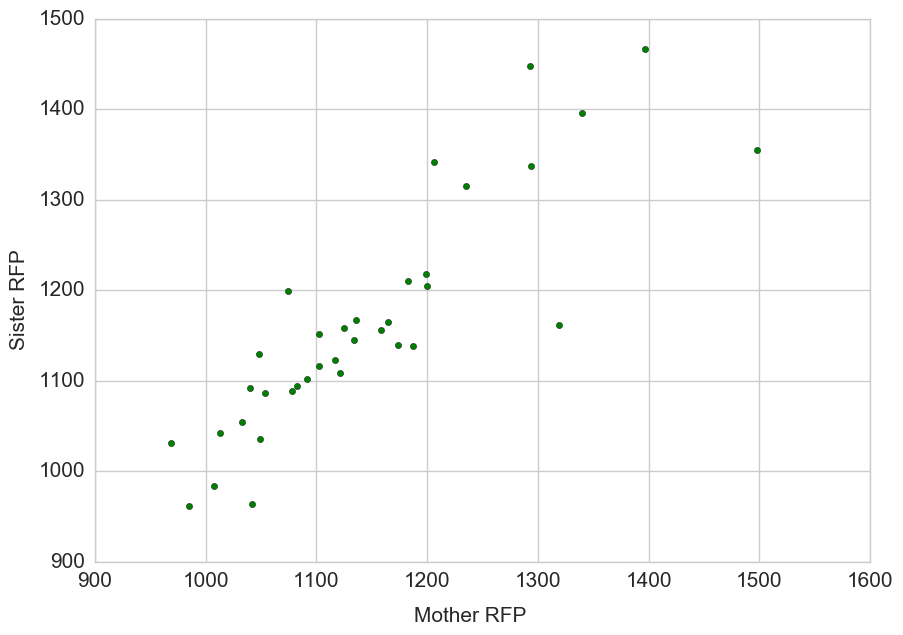

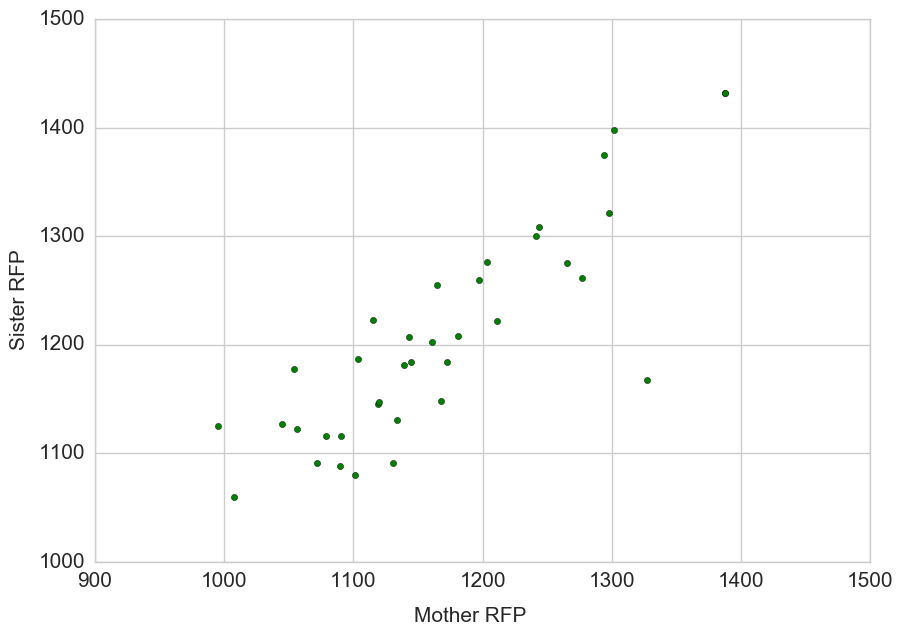

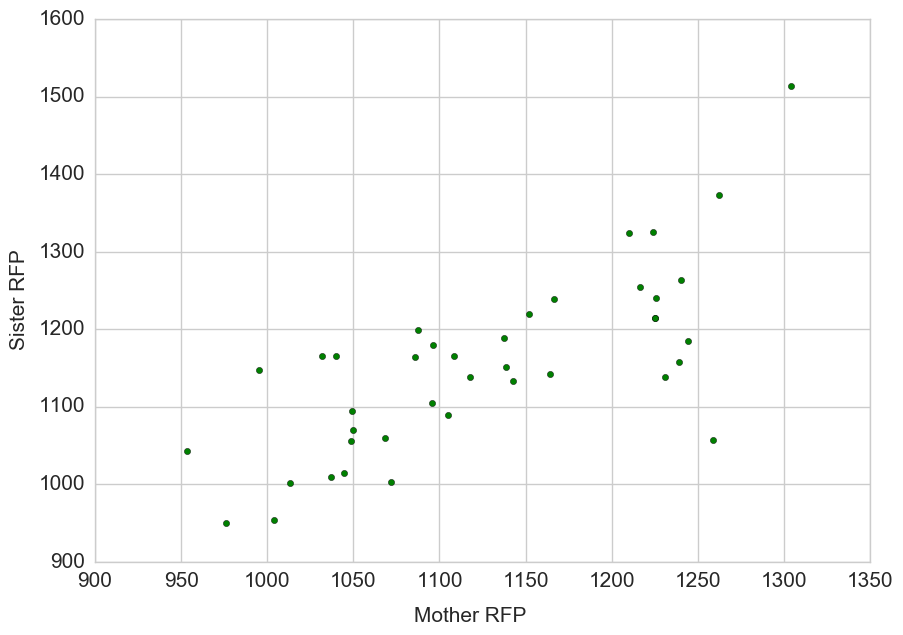

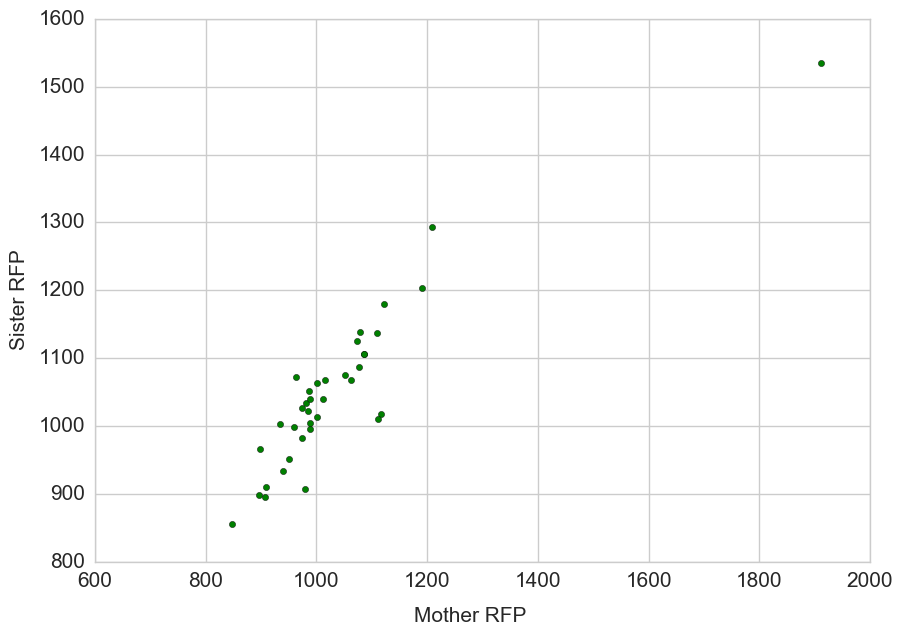

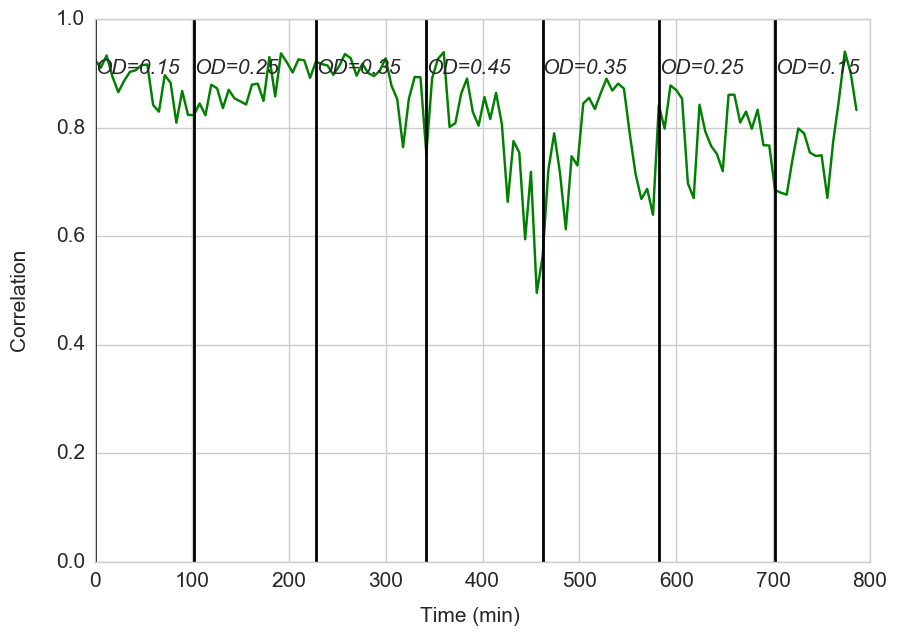

In [46]:
if not os.path.exists('./correlation'):
    os.makedirs('./correlation')
framearray = data['Frame'].unique()
frame = []
coef = []
for i in framearray:
    frame.append(data.query('Frame== '+str(i)))
for i in framearray:#frames
    mother = frame[i]['MeanRFP'].tolist()
    sister = frame[i]['SMeanRFP'].tolist()
    
    coef.append(np.corrcoef(mother,sister)[0][1])
    #print(coef[i])
    if (i%10==0):
        tim = framearray*timebetweenframes
        fig, ax = plt.subplots(1, 1, figsize=(10, 7),sharex=True)
        setplot('Mother RFP','Sister RFP')        
        ax.scatter(mother,sister,c = 'g')

tim = framearray*timebetweenframes
fig, ax = plt.subplots(1, 1, figsize=(10, 7),sharex=True)
setplot('Time (min)','Correlation')
ax.plot(tim,coef,c = 'g')
for m in range(len(ref)):
    ax.plot([ref[m], ref[m]], [0,1], 'k-', lw=2)
    ax.text(ref[m], 0.9, annotation[m], style='italic',fontsize=15)
plt.savefig('./correlation/mother-sister.png') 

## Autocorrelation ploting

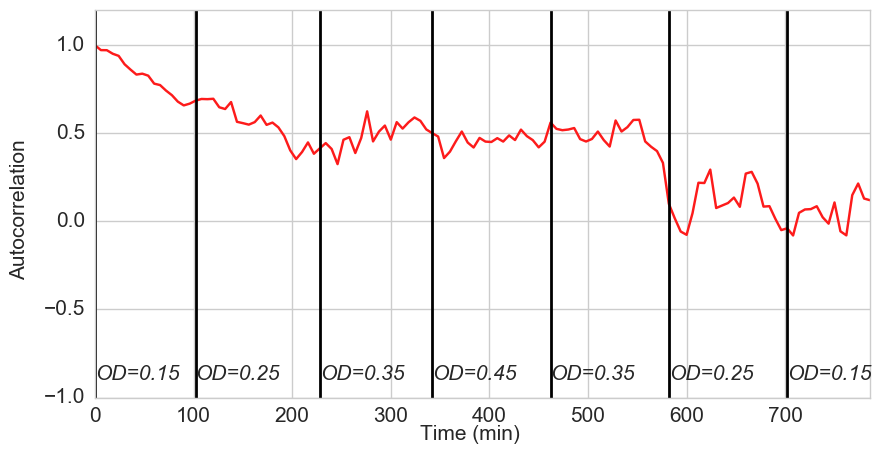

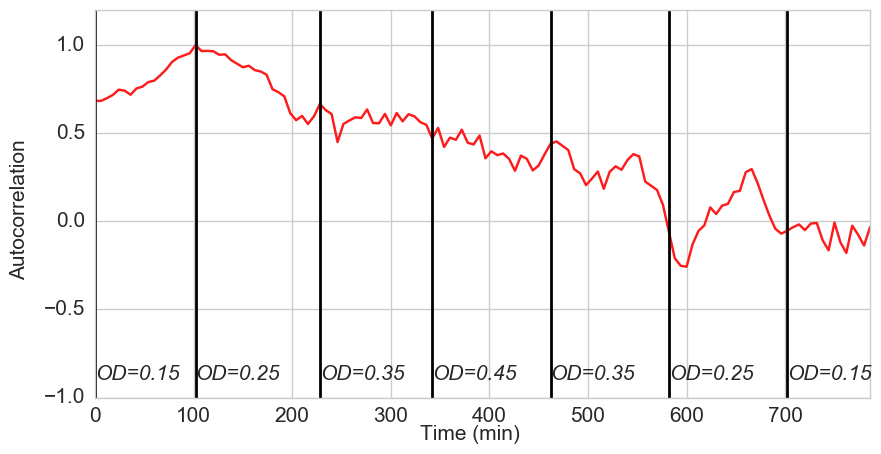

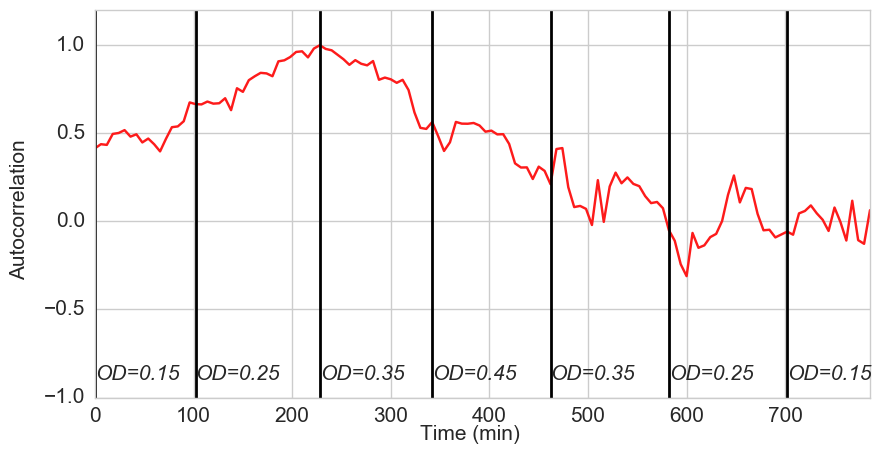

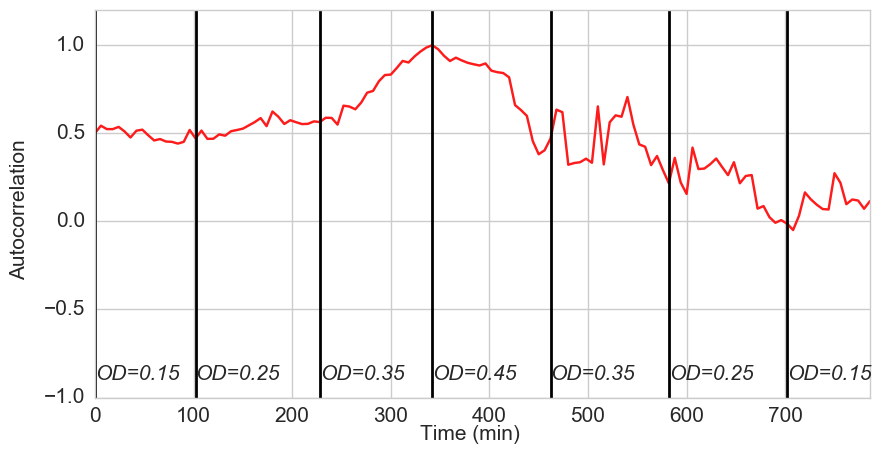

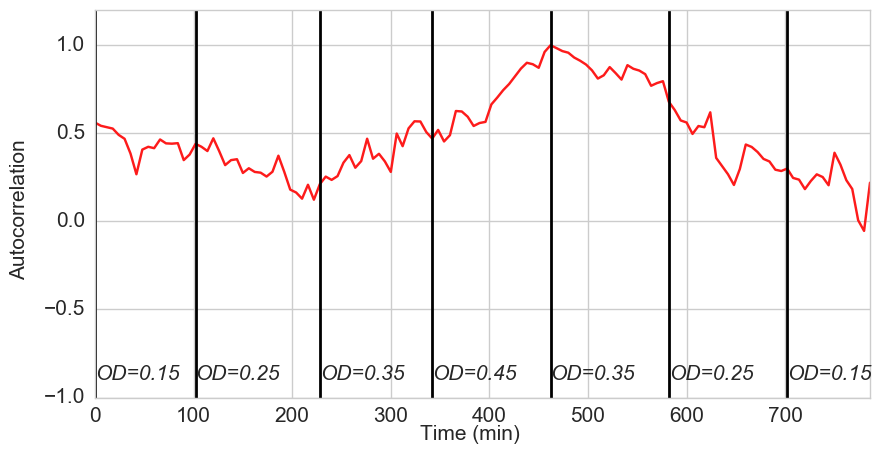

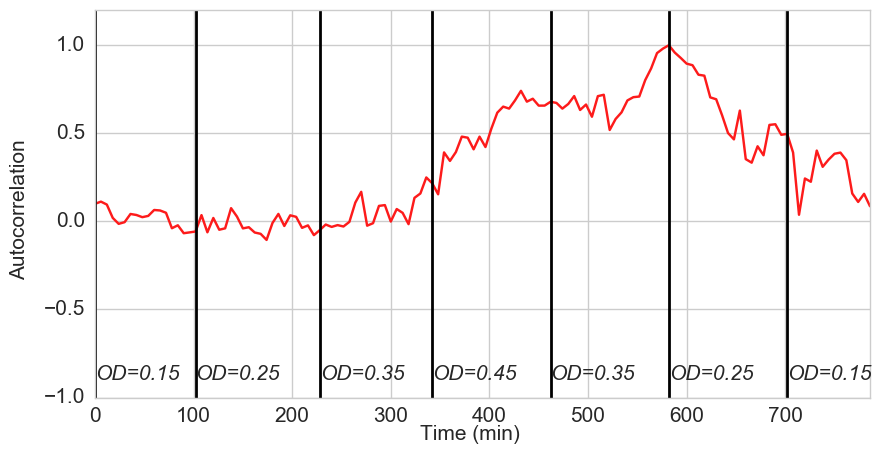

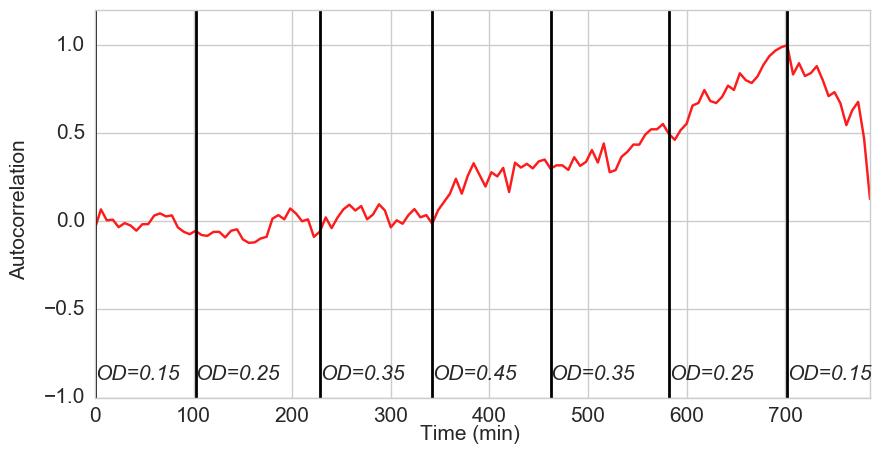

In [47]:
if not os.path.exists('./autocorrelation'):
    os.makedirs('./autocorrelation')
    
motherarray = data['Mother'].unique()
timesnap = data['Frame'].unique()
for m in referencesnap:
    coef = []
    mother1= data.query('Frame == '+str(m))#buscamos los datos de las madres en el snap de referencia.
    motherarray = mother1['Mother'].unique() # las madres que se encuentran en ese snap
    tf = []
    timeref=data[data['Frame'] == m]
    coef = []
    for t in timesnap:#t para todos los snaps
        timex=data[data['Frame'] == t]#almacenamos todos los datos de ese frame
        tf.append(t*timebetweenframes)
        motherf = []
        motherf2 = []
        for l in motherarray:#contando sobre esas madres
            a=timex['MeanRFP'][timex['Mother'] == l].tolist()#fluorescencia de la madre l en el tiempo t
            b=timeref['MeanRFP'][timeref['Mother'] == l].tolist()#fluorescencia de la madre l en el tiempo ref
            if(len(a)==1 and len(b)==1):
                motherf.append(a[0])
                motherf2.append(b[0])
        coef.append(np.corrcoef(motherf,motherf2)[0][1])
    fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=True)
    setplot('Time (min)','Autocorrelation')
    ax.plot(tf,coef,c='#FD1B1B')
    ax.set_xlim([tf[0], tf[len(tf)-1]])  
    ax.set_ylim([-1,1.2]) 
    #fig.suptitle('tau =' + str(i),fontsize=15)
    for m in range(len(ref)):
        ax.plot([ref[m], ref[m]], [-1,1.2], 'k-', lw=2)
        ax.text(ref[m], -0.9, annotation[m], style='italic',fontsize=15)
    ax.figure.savefig('./autocorrelation/RFPwith'+str(m)+'.png')
    
    
if(GFPimages):    
    motherarray = data['Mother'].unique()
    timesnap = data['Frame'].unique()
    for m in referencesnap:
        coef = []
        mother1= data.query('Frame == '+str(m))#buscamos los datos de las madres en el snap de referencia.
        motherarray = mother1['Mother'].unique() # las madres que se encuentran en ese snap
        tf = []
        timeref=data[data['Frame'] == m]
        coef = []
        for t in timesnap:#t para todos los snaps
            timex=data[data['Frame'] == t]#almacenamos todos los datos de ese frame
            tf.append(t*timebetweenframes)
            motherf = []
            motherf2 = []
            for l in motherarray:#contando sobre esas madres
                a=timex['MeanGFP'][timex['Mother'] == l].tolist()#fluorescencia de la madre l en el tiempo t
                b=timeref['MeanGFP'][timeref['Mother'] == l].tolist()#fluorescencia de la madre l en el tiempo ref
                if(len(a)==1 and len(b)==1):
                    motherf.append(a[0])
                    motherf2.append(b[0])
            coef.append(np.corrcoef(motherf,motherf2)[0][1])
        fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=True)
        setplot('Time (min)','Autocorrelation')
        ax.plot(tf,coef,c = 'g')
        ax.set_xlim([tf[0], tf[len(tf)-1]])  
        ax.set_ylim([-1,1.2]) 
        #fig.suptitle('tau =' + str(i),fontsize=15)
        for m in range(len(ref)):
            ax.plot([ref[m], ref[m]], [-1,1.2], 'k-', lw=2)
            ax.text(ref[m], -0.9, annotation[m], style='italic',fontsize=15)
        ax.figure.savefig('./autocorrelation/GFPwith'+str(m)+'.png')  

## Autocorrelation whith fixed periods

In [48]:
Periods = [1,5,10]

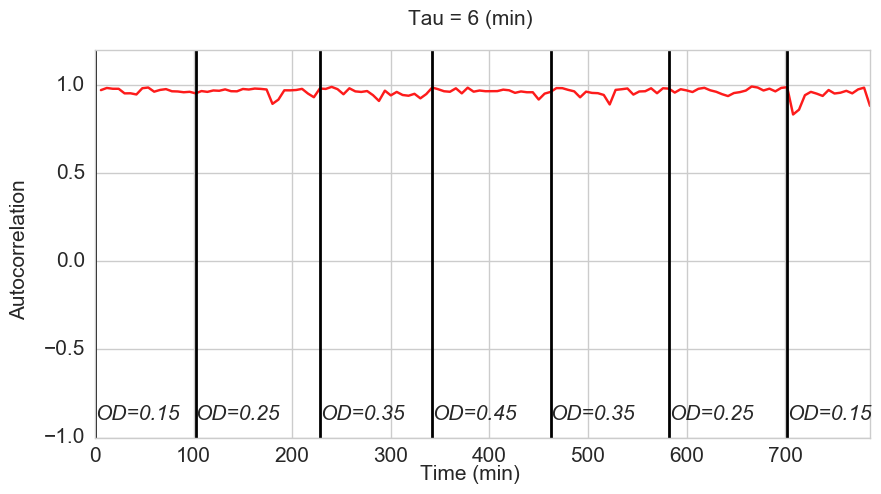

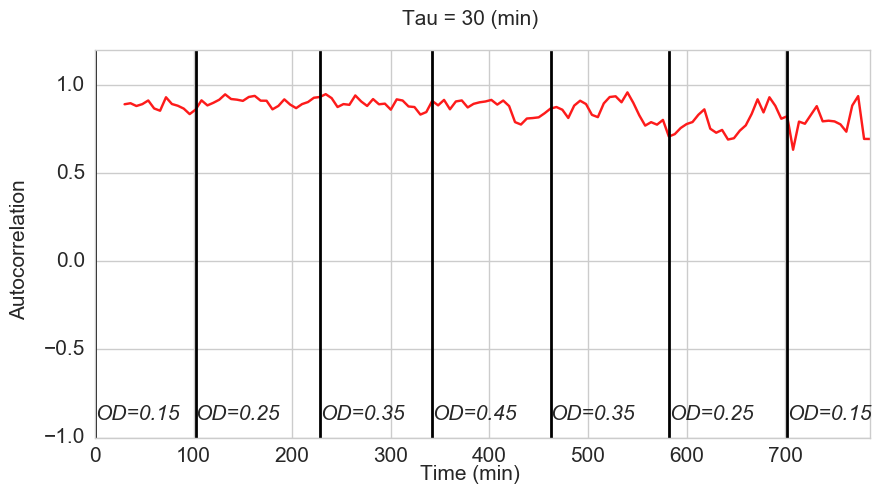

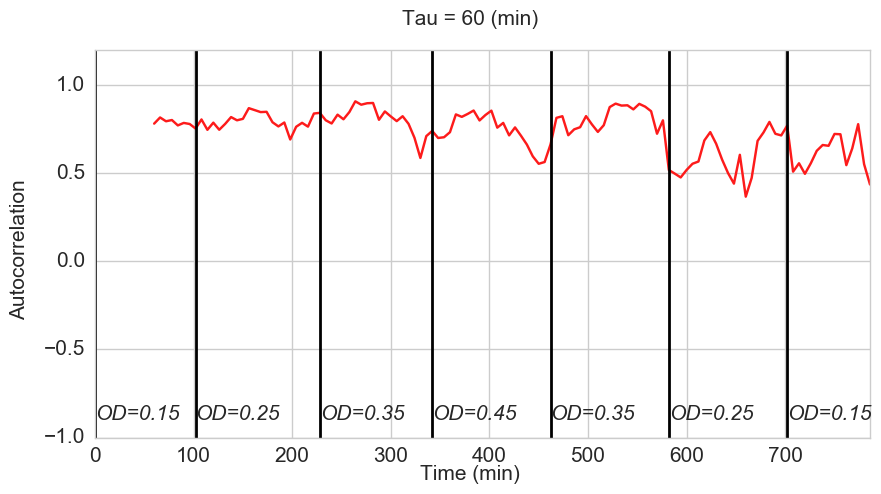

In [49]:
if not os.path.exists('./autocorrelationperiods'):
    os.makedirs('./autocorrelationperiods')
motherarray = data['Mother'].unique()
timesnap = data['Frame'].unique()
for tau in Periods:
    coef = []
    tit = []
    for t in timesnap:
        if (t-tau>=0):
            motherf =[]
            motherf2 =[]
            fluort=data[data['Frame'] == t]
            fluortau=data[data['Frame'] == t-tau]
            mother1= fluort.query('Frame == '+str(t))#buscamos los datos de las madres en el snap de referencia.
            motherarray = mother1['Mother'].unique()# las madres que se encuentran en ese snap
            for l in motherarray:#contando sobre esas madres
                a=fluort['MeanRFP'][fluort['Mother'] == l].tolist()#fluorescencia de la madre l en el tiempo t
                b=fluortau['MeanRFP'][fluortau['Mother'] == l].tolist()#fluorescencia de la madre l en el tiempo ref
                if(len(a)==1 and len(b)==1):
                    motherf.append(a[0])
                    motherf2.append(b[0])
            coef.append(np.corrcoef(motherf,motherf2)[0][1])
            tit.append(t*timebetweenframes)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=True)
    setplot('Time (min)','Autocorrelation')
    ax.plot(tit,coef,c='#FD1B1B')
    ax.set_xlim([0, tf[len(tf)-1]])  
    ax.set_ylim([-1,1.2])
    fig.suptitle('Tau = ' + str(tau*timebetweenframes)+ ' (min)',fontsize=15)
    for m in range(len(ref)):
        ax.plot([ref[m], ref[m]], [-1,1.2], 'k-', lw=2)
        ax.text(ref[m], -0.9, annotation[m], style='italic',fontsize=15)
    ax.figure.savefig('./autocorrelationperiods/RFP'+str(tau)+'.png') 

## Doubling time weighted averaging

In [50]:
ave=0
totalt=0
for i in range (len(divisiontime)):
    totalt+=divisiontime[i]
n=0
for i in range (len(td)):
    if(td[i][0]>10 and td[i][0]<500):
        ave+=td[i][0]*td[i][1]/totalt
        n+=1
averagetd=ave
std=0
for i in range (len(td)):
    if(td[i][0]>0 and td[i][0]<500):
        std+=(td[i][0]-ave)**2
errortd=np.sqrt(std/n)
averagediv=np.median(divisiontime)
errordiv=np.std(divisiontime)           
f = open("meanvalues.csv", "w")#abre y cierra en modo escritura para borrar lo que tenga adentro
f.close()
f = open("meanvalues.csv", "w")
f.write("average doubling time,"+str(float(averagetd))+"\n")
f.write("std doubling time,"+str(float(errortd))+"\n")
f.write("average division time,"+str(averagediv)+"\n")
f.write("std division time,"+str(errordiv)+"\n")
f.close()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: divide by zero encountered in true_divide
